# **Amazon Reviews - Text Classification and Explainability Methods**

**Master's Degree in Data Science (A.Y. 2024/2025)**<br/>
**University of Milano - Bicocca**<br/>
**Natural Language Processing Course**<br/>

Student: Sara **Nava**, mat. **870885**

Data source: [Amazon Reviews '23](https://amazon-reviews-2023.github.io)

**Note**: To ensure reproducibility, all models have already been saved in the recovery folder. The code can be easily rerun, either by training from scratch or by directly importing the pre-saved models.

## **Import Libraries and define Google Drive Directory**

Install the packages needed to run this project (this may take a few minutes).  

**Note**: The first installation of gensim may return errors. If this happens, restart the session and run the operation again.

In [ ]:
!pip install gensim

In [ ]:
!pip install transformers_interpret

In [ ]:
!pip install lime langdetect evaluate torchviz

In [ ]:
!git clone https://github.com/facebookresearch/fastText.git
!pip install fastText/.

Cloning into 'fastText'...
remote: Enumerating objects: 3998, done.
remote: Total 3998 (delta 0), reused 0 (delta 0), pack-reused 3998 (from 1)
Receiving objects: 100% (3998/3998), 8.30 MiB | 11.10 MiB/s, done.
Resolving deltas: 100% (2527/2527), done.
Processing ./fastText
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-3.0.1-py3-none-any.whl.metadata (10.0 kB)
Using cached pybind11-3.0.1-py3-none-any.whl (293 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp312-cp312-linux_x86_64.whl size=4498167 sha256=9efc812501ad6e5a56450828b1ac0e07412e0067a783ba4ea4d64745a7850ab2
  Stored in directory: /tmp/pip-ephem-wheel-cache-iladnqc2/wheels/23/6e/8a/c38354dc8ed418ddfd2e9f0d8eb07ee87a057a1b568d57b9ef
Successfully built fasttext


Import all necessary packages:

In [ ]:
from datasets import load_dataset
import requests
import gzip
import shutil
from google.colab import drive
import os
import pandas as pd
import re
import string
from tqdm.notebook import tqdm
import numpy as np

from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

from imblearn.combine import SMOTEENN
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

from collections import Counter
import joblib

import random

import html

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import LinearSVC
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier


import collections

import gensim.downloader
from gensim.models import Word2Vec

from IPython.display import display, HTML

from wordcloud import WordCloud
import shap
from lime.lime_text import LimeTextExplainer

import fasttext
import fasttext.util

from keras.models import Sequential

from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential, load_model

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, get_scheduler, DistilBertModel
from transformers_interpret import SequenceClassificationExplainer, MultiLabelClassificationExplainer
import transformers
from transformers import pipeline
from sentence_transformers import SentenceTransformer
import torch
from torch.utils.data import Dataset, DataLoader,  WeightedRandomSampler
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

Download `nltk` functions necessary for next steps:

In [ ]:
# Download nltk modules
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Mount google drive:

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Define working directory:

In [ ]:
# Working directory
drive_folder = "/content/drive/MyDrive/NLP_Data_Science"
# Dataset folder
data_folder_name = "amazon_reviews"

Create dataset repository if doesn't exist:

In [ ]:
# Create repository in the google drive project directory
if data_folder_name not in os.listdir(drive_folder):
  os.makedirs(f"{drive_folder}/{data_folder_name}", exist_ok=True)
  print(f'Dataset repository {data_folder_name} correctly created in {drive_folder}.')
else:
  print(f'Dataset repository {data_folder_name} already exists in {drive_folder}.')

Dataset repository amazon_reviews already exists in /content/drive/MyDrive/NLP_Data_Science.


Define dataset repository path:

In [ ]:
dataset_folder_path = f"{drive_folder}/{data_folder_name}"

Define also a recovery folder:

In [ ]:
# Ensure recovery folder exists
recovery_dir = f"{drive_folder}/recovery"
os.makedirs(recovery_dir, exist_ok=True)

## **Download and Import Data**

Select a **product category** from the available ones. It’s important to choose a subset of reviews with a manageable size (not too large and not too small), since the available resources are limited and the tasks to be performed are computationally intensive.

`All_Beauty` contains **74.1M beauty product reviews**, one of the smaller subsets. Beauty products are often highly subjective, making their reviews detailed and potentially very valuable for text classification tasks.

In [ ]:
# Product category
categ_prod = 'All_Beauty'

# data URLs
urls = {
    'reviews':f"https://mcauleylab.ucsd.edu/public_datasets/data/amazon_2023/raw/review_categories/{categ_prod}.jsonl.gz",
    'meta':f"https://mcauleylab.ucsd.edu/public_datasets/data/amazon_2023/raw/meta_categories/meta_{categ_prod}.jsonl.gz"
    }

Download reviews and metadata related to reviewed products.

In [ ]:
# Download if not existing
for name, url in urls.items():
  filepath = os.path.join(dataset_folder_path, os.path.basename(url))
  if not os.path.exists(filepath):
      print(f"Downloading {name}...")
      with requests.get(url, stream=True) as r:
          with open(filepath, "wb") as f:
              shutil.copyfileobj(r.raw, f)
      print(f"Saved {name} to {filepath}")
  else:
      print(f"{name} already exists at {filepath}")

reviews already exists at /content/drive/MyDrive/NLP_Data_Science/amazon_reviews/All_Beauty.jsonl.gz
meta already exists at /content/drive/MyDrive/NLP_Data_Science/amazon_reviews/meta_All_Beauty.jsonl.gz


Now, read data and display datasets' headers:

In [ ]:
# Import datasets
# Define path
reviews_path = os.path.join(dataset_folder_path, f"{categ_prod}.jsonl.gz")
meta_path = os.path.join(dataset_folder_path, f"meta_{categ_prod}.jsonl.gz")

# Read files
reviews = pd.read_json(reviews_path, lines=True, compression="gzip")
meta = pd.read_json(meta_path, lines=True, compression="gzip")
print("Reviews shape:", reviews.shape)
print("Meta shape:", meta.shape)

Reviews shape: (701528, 10)
Meta shape: (112590, 14)


In [ ]:
reviews.head(3)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-05 14:08:48.923,0,True
1,4,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-04 18:10:55.070,1,True
2,5,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,2020-05-16 21:41:06.052,2,True


In [ ]:
meta.head(3)

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together
0,All Beauty,"Howard LC0008 Leather Conditioner, 8-Ounce (4-...",4.8,10,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Howard Products,[],{'Package Dimensions': '7.1 x 5.5 x 3 inches; ...,B01CUPMQZE,NaN
1,All Beauty,Yes to Tomatoes Detoxifying Charcoal Cleanser ...,4.5,3,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Yes To,[],"{'Item Form': 'Powder', 'Skin Type': 'Acne Pro...",B076WQZGPM,NaN
2,All Beauty,Eye Patch Black Adult with Tie Band (6 Per Pack),4.4,26,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Levine Health Products,[],{'Manufacturer': 'Levine Health Products'},B000B658RI,NaN


**Reviews dataset** contains individual product reviews with fields such as:  
  - `rating` (1–5 stars)  
  - `title` and `text` (review content)  
  - `asin` / `parent_asin` (product identifiers)  
  - `user_id`, `timestamp` (review metadata)  
  - `helpful_vote`, `verified_purchase`, and optional `images`  

It's useful for **text classification** and studying user feedback.  

Instead, **Metadata dataset** provides product-level information. It can be useful for **contextualizing reviews** and linking them to richer product attributes, but not significant for this project.

## **Dataset Pre-processing and Data Quality Check**

Reviews can be quite noisy: they may contain links, user-added metadata and other elements that do not carry semantic meaning.  
To improve text quality for classification, it is a good idea to remove these artifacts, regardless of the specific model used.

The following preprocessing steps will be applied:

- **Remove HTML tags** (e.g., `<br>`).  
- **Remove placeholders** (e.g., `[[VIDEOID:...]]`).  
- **Remove URLs**.   
- **Collapse repeated punctuation** (e.g., `"!!!!"` → `"!"`).  
- **Strip extra whitespace**.  

In [ ]:
# Define a cleaning function
def clean_text(text):
    text = str(text)
    # Remove HTML tags
    text = re.sub(r"<.*?>", " ", text)
    # Remove video IDs or placeholders [[VIDEOID:xxxx]]
    text = re.sub(r"\[\[.*?\]\]", " ", text)
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", " ", text)
    # Collapse repeated punctuation (!!! → !, ??? → ?)
    text = re.sub(r"([!?.,])\1+", r"\1", text)
    # Collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Clean reviews
clean_reviews = reviews.copy() # Create a copy for recovery
clean_reviews['text'] = reviews['text'].apply(clean_text)

The reviews dataset contains around **700k beauty product reviews**.  
However, this size is **still too large** and can be reduced by applying some filters:

- To reduce the dimensionality of the original dataset, it is necessary to ensure that the distribution of classes is preserved, so as not to excessively distort reality. For this reason, a **fixed size of 50k reviews** is chosen for the final dataset.
- Although multilingual embedding models exist (e.g., `google-bert/bert-base-multilingual-cased`), it is better to **filter reviews written only in English**. This can be done using the `langdetect` library, selecting only reviews classified as `'en'`.

For the moment, start filtering the dataset setting a threshold of at least **20 reviews per product** to remove less reviewed products (they could introduce noise within trained dictionaries).

**Note**: the metadata dataset contains, for each product, the number of ratings. Before relying on it, verify whether this value aligns with the number of reviews. It is possible that some ratings come from users who did not write a textual review, so the counts may not match exactly.

In [ ]:
# Verify if numbers match
asin_count = clean_reviews.parent_asin.value_counts().reset_index()
asin_count = pd.merge(asin_count, meta[['parent_asin', 'rating_number']], on='parent_asin', how='inner')

In [ ]:
print(f"Products with matching counting: {asin_count[asin_count['count'] == asin_count['rating_number']].shape[0]} of {meta.shape[0]}")
asin_count[asin_count['count'] == asin_count['rating_number']]

Products with matching counting: 14814 of 112590


,parent_asin,count,rating_number
2187,B0062CNT12,45,45
4479,B09QNWCGQK,25,25
5596,B072MZKZRS,21,21
5911,B0116B823I,20,20
5943,B01BNE6OGU,20,20
...,...,...,...
112537,B01J96FIP2,1,1
112550,B09JQGL9PC,1,1
112559,B0BNQ6JKYJ,1,1
112560,B094C7M695,1,1


Since the numbers don't match, and when this happens, it happens for products with few reviews, it's better to rely only on the number of existing reviews for each product present in `reviews` dataset.

In [ ]:
# Extract the list of product IDs (parent_asin) with at least 20 reviews
asin_count = clean_reviews.parent_asin.value_counts().reset_index()
asin_list = asin_count.loc[asin_count['count']>= 20, 'parent_asin'].to_list()
# Create the subset
reviews_subset = clean_reviews[clean_reviews.parent_asin.isin(asin_list)].reset_index(drop=True)
print(f"The number of reviews has been reduced from {clean_reviews.shape[0]} to {reviews_subset.shape[0]}")

The number of reviews has been reduced from 701528 to 365702


Now, select only **english reviews**. Considering some bottlenecks of `langdetect` library in handling short text, concatenate title and reviews to augment textual length.

In [ ]:
# Define a function to handle exceptions
def detect_language(text):
  # Reduce text length to reduce computational costs
  if len(text)>50:
    text = text[:50]
  try:
      return detect(text)
  except LangDetectException:
      return "null"

# Define file path
cache_path = os.path.join(recovery_dir, "reviews_lang.csv")

# Check if language detection has already been applied
if os.path.exists(cache_path):
  print(f"Language detection has already been applied. Importing data.")
  reviews_lang = pd.read_csv(cache_path)
else:
  # Work on a copy and handle missing values
  reviews_lang = reviews_subset.copy()
  reviews_lang["title"] = reviews_lang["title"].fillna("")
  reviews_lang["text"]  = reviews_lang["text"].fillna("")

  # Concatenate title + text
  reviews_lang["title_text"] = reviews_lang["title"] + " " + reviews_lang["text"]

  # Detect language with a progress bar
  reviews_lang["lang"] = reviews_lang["title_text"].progress_apply(detect_language)

  # Cache to Drive
  reviews_lang.to_csv(cache_path, index=False)

Language detection has already been applied. Importing data.


In [ ]:
# Check language distribution
# Frequency of detected languages
lang_counts = reviews_lang['lang'].value_counts()

# Top 5 most frequent
top5 = lang_counts.head(5)

# Bottom 5 least frequent
bottom5 = lang_counts.tail(5)

print("Top 5:\n", top5)
print("\nBottom 5:\n", bottom5)

Top 5:
 lang
en    347761
es      4808
af      2550
ro      1346
no      1163
Name: count, dtype: int64

Bottom 5:
 lang
cs    42
tr    37
sw    30
lt    13
lv     5
Name: count, dtype: int64


From `reviews_subset`, keep only english reviews:

In [ ]:
# Filter data
reviews_subset_en = reviews_lang.loc[reviews_lang.lang == 'en']
reviews_subset_en = reviews_subset_en.drop(columns=['title_text', 'lang'])

# Check
print(f'Before language detection: {reviews_subset.shape[0]} reviews.')
print(f'After language detection: {reviews_subset_en.shape[0]} reviews.')

Before language detection: 365702 reviews.
After language detection: 347761 reviews.


Since each review has a rating betwwen 1 and 5, to reduce noise convert it into a new scale, following this criteria:
- 1-2 points: **bad**
- 3 points: **neutral**
- 4-5 points: **good**

In [ ]:
# Define conversion function
def vote_conversion(rating):
  if rating < 3:
    return 'bad'
  elif rating > 3:
    return 'good'
  else:
    return 'neutral'

# Apply it on ratings
reviews_subset_en['vote'] = reviews_subset_en.rating.apply(lambda x: vote_conversion(x))

Drop null values:

In [ ]:
# Remove nan
reviews_subset_en = reviews_subset_en.dropna(subset=["text"])

Since the dataset size is still relatively large, and in this project is expected to apply heavy models, it is reasonable to **reduce the dimension of the dataset to 50000**, keeping the same classes proportions in the orginal english dataset.

In [ ]:
# Print vote's proportions
reviews_subset_en['vote'].value_counts()/len(reviews_subset_en['vote'])

,count
vote,
good,0.731098
bad,0.189628
neutral,0.079273


In [ ]:
# Stratified sampling to preserve vote proportions
reviews_subset_en, _ = train_test_split(
    reviews_subset_en,
    train_size=50000,
    stratify=reviews_subset_en['vote'],
    random_state=42
)
print(f"The number of reviews has been reduced from {clean_reviews.shape[0]} to {reviews_subset_en.shape[0]}")

The number of reviews has been reduced from 701528 to 50000


In [ ]:
# Print vote's proportions
reviews_subset_en['vote'].value_counts()/len(reviews_subset_en['vote'])

,count
vote,
good,0.73110
bad,0.18962
neutral,0.07928


Print the final dataset ready for next steps:

In [ ]:
# Select useful columns
amazon_df = reviews_subset_en[['parent_asin', 'user_id', 'timestamp', 'text', 'vote']].reset_index(drop=True)
amazon_df.head(3)

,parent_asin,user_id,timestamp,text,vote
0,B01GS7QKQQ,AEHY76JX23466SYNSDUUKJFSC5EA,2017-06-28 06:19:23.207,"I had dry hair, especially in this hot summer ...",good
1,B01EKSKUL6,AEELLTORQUTIPWKJ7SONCQ32XP7A,2017-12-17 16:58:09.083,"These files are awesome, and look very elegant...",good
2,B01M4M0CT7,AF27LPI2BQ4FOQ5HMKAF5R5D5TZA,2018-02-23 19:16:27.582,Pretty colors! To many wrap arounds!,bad


Save for recovery:

In [ ]:
# Save in csv file, within recovery folder
finaldf_path = os.path.join(recovery_dir, "amazon_df.csv")
amazon_df.to_csv(finaldf_path, index=False)

## **Classification Models**

Import dataset if it's not been created yet:

In [ ]:
# Import data
finaldf_path = os.path.join(recovery_dir, "amazon_df.csv")
if 'amazon_df' not in locals():
    print('Importing data.')
    amazon_df = pd.read_csv(finaldf_path)
else:
    print('The final dataset already exists.')

Importing data.


In [ ]:
# Check vote distribution
amazon_df.vote.value_counts()

,count
vote,
good,36555
bad,9481
neutral,3964


**Note**: since the dataset is particularly unbalanced with the respect to `vote` feature, it is necessary to adopt a unique and sensible criterion for dealing with the imbalance during model training, so that each approach is comparable.

Oversampling in this case could be risky because, in order to reach the size of the majority class, the minority classes would have to undergo multiple duplications, risking that the model would overfit that class as it learns too much about the specific training information. On the other hand, reducing the information of the majority class would mean losing a significant amount of information, limiting training.

The most sensible approach is **class weighting**: in this way, the model in the training phase assigns greater weight to minority classes, reducing bias with respect to the majority.

In scikit-learn classification models such `LinearSVM` it's enough to specify the argument `class_weight=True` to perform class weighting. `MLP` instead doesn't support it. Thus, implement MLP classifier leveraging other libraries (`torch`). Thus, define a class to implement the MLP and allowing reproducibility:

### **Functions:**

Define useful functions to improve code readability and avoid redundant code.

In [ ]:
# Define TorchMLP for nn training
class TorchMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(TorchMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define MLP with Class Weighting
def MLPClassWeighting(X_train_array, y_train, epochs, hidden_dim, lr, trained=False):
  # Compute class weights
  classes = np.unique(y_train)
  # sklearn's balanced formula
  weights = compute_class_weight(class_weight="balanced",
                                classes=classes,
                                y=y_train)
  # Convert to tensor for PyTorch
  class_weights = torch.tensor(weights, dtype=torch.float32)
  # Define loss with weights
  criterion = nn.CrossEntropyLoss(weight=class_weights.to("cpu"))

  # Define input dimensions and classes
  input_dim = X_train_array.shape[1]
  num_classes = len(label_encoder.classes_)

  if trained == True:
    return input_dim, num_classes

  # Define MLP
  mlp = TorchMLP(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes)

  optimizer = AdamW(mlp.parameters(), lr=lr)
  X_train_tensor = torch.tensor(X_train_array, dtype=torch.float32)
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)

  # training loop
  for epoch in range(epochs):
      mlp.train()
      optimizer.zero_grad()
      outputs = mlp(X_train_tensor)
      loss = criterion(outputs, y_train_tensor)
      loss.backward()
      optimizer.step()
      if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

  return mlp

In [ ]:
# SVM (class weighting)
def SVM_training(file_path, X_train, y_train):
  if os.path.exists(file_path):
    print("SVM already trained. Importing classifier..")
    svm_weighted = joblib.load(file_path)

  else:
    print("Training SVM classifier on data..")
    svm_weighted = LinearSVC(random_state=42, class_weight='balanced')
    svm_weighted.fit(X_train, y_train)

    # Save trained model
    joblib.dump(svm_weighted, file_path)

  return svm_weighted

# MLP (class weighting)
def MLP_training(mlp_model_path, X_train, y_train, epochs=300, hidden_dim=100, lr=1e-3):
  if os.path.exists(mlp_model_path):
      print("TorchMLP found. Loading...")
      input_dim, num_classes = MLPClassWeighting(X_train, y_train, epochs, hidden_dim, lr, trained=True)
      mlp = TorchMLP(input_dim, hidden_dim, num_classes=num_classes)
      mlp.load_state_dict(torch.load(mlp_model_path))
      mlp.eval()
  else:
      print("TorchMLP not found. Training new model...")
      mlp = MLPClassWeighting(X_train, y_train, epochs, hidden_dim, lr)

      # save model
      torch.save(mlp.state_dict(), mlp_model_path)
      print("TorchMLP saved.")

  return mlp

# Mean pooling vectorizer
def mean_pooling_vectorize(sentence, model):
    words = sentence.split()

    words_vecs = [model.wv[word] for word in words if word in model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

In [ ]:
# LSTM pipeline
def create_embedding_matrix(word_index, embedding_model, embedding_dim):
    # Initialize an empty embedding matrix (words × embedding_dim)
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        vector = None

        # Case 1: official Facebook fastText
        if hasattr(embedding_model, "get_word_vector"):
            vector = embedding_model.get_word_vector(word)

        # Case 2: gensim KeyedVectors (Word2Vec / FastText)
        elif hasattr(embedding_model, "index_to_key"):
            if word in embedding_model:
                vector = embedding_model[word]

        # Case 3: Python dictionary (e.g., GloVe loaded manually)
        elif isinstance(embedding_model, dict):
            vector = embedding_model.get(word)

        # If the vector was found, assign it to the corresponding index
        if vector is not None:
            embedding_matrix[i] = vector
    return embedding_matrix


def get_embedding_dim(embedding_model):
    # Case 1: official Facebook fastText
    if hasattr(embedding_model, "get_dimension"):
        return embedding_model.get_dimension()
    # Case 2: gensim Word2Vec / FastText
    if hasattr(embedding_model, "vector_size"):
        return embedding_model.vector_size
    # Case 3: gensim KeyedVectors
    if hasattr(embedding_model, "index_to_key"):
        first_key = embedding_model.index_to_key[0]
        return len(embedding_model[first_key])
    # Case 4: Python dictionary (e.g., GloVe)
    if isinstance(embedding_model, dict):
        first_key = next(iter(embedding_model.keys()))
        return len(embedding_model[first_key])
    # If none of the above match, raise an error
    raise ValueError("Unsupported embedding model type")



# LSTM model architecture
def create_lstm_classifier(vocab_size, embedding_dim, embedding_matrix, max_len, num_classes, bidirectional, trainable=False):
    model = Sequential()
    model.add(Embedding(
        input_dim=vocab_size + 1,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=trainable
    ))
    # LSTM layer
    if bidirectional==True:
        model.add(Bidirectional(LSTM(128, return_sequences=False)))
    else:
        model.add(LSTM(128, return_sequences=False))
    # Other layers
    model.add(Dropout(0.5))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Adam(learning_rate=1e-3),
        metrics=["accuracy"]
    )
    return model

def tokenize_lstm(X_train_texts, X_test_texts, max_num_words=50000, max_sequence_length=100):
  # Tokenization
  tokenizer = Tokenizer(num_words=max_num_words)
  tokenizer.fit_on_texts(X_train_texts)

  X_train = tokenizer.texts_to_sequences(X_train_texts)
  X_test  = tokenizer.texts_to_sequences(X_test_texts)

  X_train = pad_sequences(X_train, maxlen=max_sequence_length)
  X_test  = pad_sequences(X_test, maxlen=max_sequence_length)
  return tokenizer, X_train, X_test


# Training wrapper
def Train_LSTM_classifier(
    model_path, embedding_model,X_train_texts, y_train_raw, X_test_texts, max_num_words=50000,
    max_sequence_length=100, is_gensim=True, epochs=10, batch_size=64, bidirectional=False):

    # If model exists, just load it
    if os.path.exists(model_path):
        print("LSTM model already trained. Importing...")
        model = load_model(model_path)
        return model

    # Tokenization
    tokenizer, X_train, X_test = tokenize_lstm(X_train_texts, X_test_texts, max_num_words=max_num_words, max_sequence_length=max_sequence_length)
    word_index = tokenizer.word_index
    print("Vocabulary size:", len(word_index))

    # Embedding dim + matrix
    edim = get_embedding_dim(embedding_model)
    embedding_matrix = create_embedding_matrix(word_index, embedding_model, edim)


    # Model
    num_classes = len(np.unique(y_train_raw))
    model = create_lstm_classifier(
        vocab_size=len(word_index),
        embedding_dim=embedding_matrix.shape[1],
        embedding_matrix=embedding_matrix,
        max_len=max_sequence_length,
        num_classes=num_classes,
        bidirectional=bidirectional,
        trainable=False)

    # Class Weights
    classes = np.unique(y_train_raw)
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=classes,
        y=y_train_raw)
    class_weights = dict(zip(classes, class_weights))
    print("Class Weights:", class_weights)

    # Add early stopping
    early_stop = EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    )

    # Training
    history = model.fit(
        X_train, y_train_raw,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weights,
        verbose=1,
        callbacks=[early_stop])

    # Save
    model.save(model_path)
    print(f"Model saved at {model_path}")

    return model

Now, proceed using different approaches for text representation, from more traditional to advanced models.

### **TF-IDF**

Start with a **traditional approach**, based on a count-based representation (**TF-IDF**) combined with a Machine Learning model.  

It is important to proceed gradually in model selection, exploring different approaches from basic to more complex ones. Simpler approaches do not necessarily mean lower performance.  <br/><br/>

**Preprocessing Recap** <br/>
The following cleaning steps have already been applied in previous steps:

- Remove HTML tags (e.g., `<br>`).  
- Remove placeholders (e.g., `[[VIDEOID:...]]`).  
- Remove URLs.  
- Collapse repeated punctuation (e.g., `"!!!!"` → `"!"`).  
- Strip extra whitespace.  <br/><br/>

**Additional Text Pre-Processing**

Now, for this specific approach, it's necessary to apply the following additional operations:

- **Apply lowercase**
- **Remove emojis / non-text symbols**.  
- **Remove stop words**
- **Remove punctuation**
- **Apply lemmatization**

In [ ]:
# Create a copy for recovery
amazon_tfidf = amazon_df.copy()

In [ ]:
# Get stop words
stop_words = set(stopwords.words('english'))
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def tfidf_preprocess(text, stop_words):
    # Lowercase
    text = str(text).lower()
    # Remove emojis and non-alphabetic symbols
    text = re.sub(r'[^a-z\s]', ' ', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [t for t in tokens if t not in stop_words]
    # Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Rejoin
    return " ".join(tokens)

Apply on dataset:

In [ ]:
# Apply tfidf_preprocess
amazon_tfidf = amazon_tfidf.rename(columns={'text':'text_old'})
tqdm.pandas()
amazon_tfidf['text'] = amazon_tfidf['text_old'].progress_apply(lambda x: tfidf_preprocess(x, stop_words))

  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
print('Before: ', amazon_tfidf.loc[0, 'text_old'])
print('After: ', amazon_tfidf.loc[0, 'text'])

Before:  I had dry hair, especially in this hot summer weather. I tried this for few days and all I can say is, &#34;goodbye dry hair&#34;! My hair became smoother and healthier. I tried different hair shampoos and conditioners before but the best one comes with the Argan Oil!
After:  dry hair especially hot summer weather tried day say goodbye dry hair hair became smoother healthier tried different hair shampoo conditioner best one come argan oil


Split data into training and test sets and then get text representation with TF-IDF Vectorizer. Specify a range (1,2) to obtain both unigrams and bigrams.

In [ ]:
# Preprocessed text and labels
texts = amazon_tfidf["text"].tolist()
labels = amazon_tfidf["vote"]

label_encoder = LabelEncoder()
y_all = label_encoder.fit_transform(labels)

# Split BEFORE TF-IDF
X_train_texts, X_test_texts, y_train_raw, y_test_raw = train_test_split(
    texts, y_all, test_size=0.2, stratify=y_all, random_state=42
)

# Fit TF-IDF only on original training texts
project_dir = f"{recovery_dir}/TFIDF"
file_path = f"{project_dir}/tfidf_vectorizer.pkl"

if os.path.exists(file_path):
    print("TF-IDF vectorizer already exists. Importing..")
    tfidf = joblib.load(file_path)
else:
    print("TF-IDF vectorizer doesn't exist. Creating..")
    tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.9)
    tfidf.fit(X_train_texts)
    joblib.dump(tfidf, file_path)

# Transform training and test sets before balancing
X_train_tfidf = tfidf.transform(X_train_texts)
X_test_tfidf = tfidf.transform(X_test_texts)

TF-IDF vectorizer already exists. Importing..


Apply a **Support Vector Machine** to classify sentences, handling the class imbalance problem with **class weighting**.

In [ ]:
# Import or initialize and train classifier
svm_weighted = SVM_training(X_train=X_train_tfidf, y_train=y_train_raw, file_path=f"{project_dir}/svm_weighted.pkl")

# Predict
y_pred = svm_weighted.predict(X_test_tfidf)

# Evaluate
print("SVM")
print(classification_report(y_test_raw, y_pred, target_names=label_encoder.classes_))

SVM already trained. Importing classifier..
SVM
              precision    recall  f1-score   support

         bad       0.70      0.69      0.69      1896
        good       0.90      0.92      0.91      7311
     neutral       0.28      0.21      0.24       793

    accuracy                           0.82     10000
   macro avg       0.62      0.61      0.61     10000
weighted avg       0.81      0.82      0.82     10000



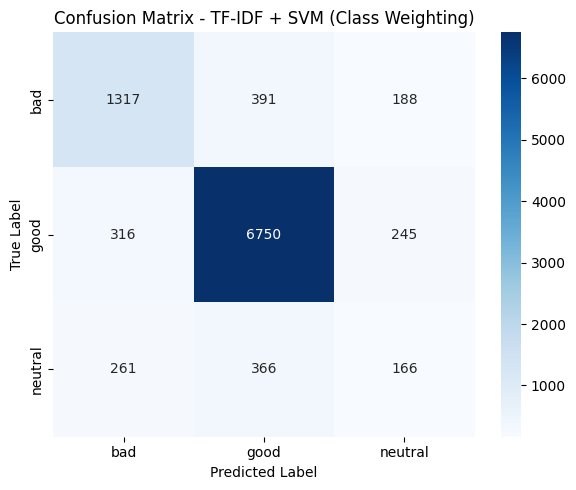

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test_raw, y_pred)
labels = label_encoder.classes_

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - TF-IDF + SVM (Class Weighting)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

The model achieves an overall **accuracy of 82%** and a **weighted F1 of 0.82**, which indicates strong performance on the dataset as a whole.  

- **Good reviews** dominate the dataset and are classified very well.  
- **Bad reviews** are reasonably detected, though there is still confusion with *good*.  
- **Neutral reviews** perform poorly, being frequently misclassified as either *bad* or *good*.  

**Macro-F1 (0.61)** is notably lower than accuracy, showing that performance is not consistent across classes and that *neutral* remains the most challenging category.  

Considering the confusion matrix:
- Many *bad* reviews are correctly identified, but about 19% are mistaken for *good*.  
- *Good* reviews are very robust, though some are confused with other classes.  
- *Neutral* reviews are heavily misclassified: more often predicted as *bad* or *good* than correctly recognized.  

Since class balancing was applied, the poor performance on *neutral* is not due solely to imbalance. It is more related to the **semantic vagueness of neutrality** and the **limits of TF-IDF**, which cannot model subtle distinctions. Improvements may come from more expressive text representations (e.g., embeddings, transformers).

### **TF-IDF (1,2,3-grams)**

Repeat the same procedure with TF-IDF + SVM, but instead of considering only unigrams and bigrams, **add also trigrams**.

In [ ]:
# Create a copy for recovery
amazon_tfidf2 = amazon_df.copy()

In [ ]:
# Get stop words
stop_words = set(stopwords.words('english'))
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def tfidf_preprocess(text, stop_words):
    # Lowercase
    text = str(text).lower()
    # Remove emojis and non-alphabetic symbols
    text = re.sub(r'[^a-z\s]', ' ', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [t for t in tokens if t not in stop_words]
    # Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Rejoin
    return " ".join(tokens)

Apply on dataset:

In [ ]:
# Apply tfidf_preprocess
amazon_tfidf2 = amazon_tfidf2.rename(columns={'text':'text_old'})
tqdm.pandas()
amazon_tfidf2['text'] = amazon_tfidf2['text_old'].progress_apply(lambda x: tfidf_preprocess(x, stop_words))

  0%|          | 0/50000 [00:00<?, ?it/s]

Split data into training and test sets and then get text representation with TF-IDF Vectorizer. Specify a range (1,3) to obtain both unigrams, bigrams and trigrams.

In [ ]:
# Preprocessed text and labels
texts = amazon_tfidf2["text"].tolist()
labels = amazon_tfidf2["vote"]

label_encoder = LabelEncoder()
y_all = label_encoder.fit_transform(labels)

# Split BEFORE TF-IDF
X_train_texts, X_test_texts, y_train_raw, y_test_raw = train_test_split(
    texts, y_all, test_size=0.2, stratify=y_all, random_state=42)

# Fit TF-IDF only on original training texts
project_dir = f"{recovery_dir}/TFIDF"
file_path = f"{project_dir}/tfidf_vectorizer_123.pkl"

if os.path.exists(file_path):
    print("TF-IDF vectorizer already exists. Importing..")
    tfidf = joblib.load(file_path)

else:
    print("TF-IDF vectorizer doesn't exist. Creating..")
    tfidf = TfidfVectorizer(ngram_range=(1,3), min_df=2, max_df=0.9)
    tfidf.fit(X_train_texts)
    joblib.dump(tfidf, file_path)

# Transform training and test sets before balancing
X_train_tfidf = tfidf.transform(X_train_texts)
X_test_tfidf = tfidf.transform(X_test_texts)

TF-IDF vectorizer already exists. Importing..


Apply a **Support Vector Machine** to classify sentences, handling the class imbalance problem with **class weighting strategy**.

In [ ]:
# Import or initialize and train classifier
svm_weighted = SVM_training(X_train=X_train_tfidf, y_train=y_train_raw, file_path=f"{project_dir}/svm_weighted_123.pkl")

# Predict
y_pred = svm_weighted.predict(X_test_tfidf)

# Evaluate
print("SVM")
print(classification_report(y_test_raw, y_pred, target_names=label_encoder.classes_))

SVM already trained. Importing classifier..
SVM
              precision    recall  f1-score   support

         bad       0.70      0.70      0.70      1896
        good       0.90      0.93      0.91      7311
     neutral       0.29      0.21      0.25       793

    accuracy                           0.83     10000
   macro avg       0.63      0.61      0.62     10000
weighted avg       0.81      0.83      0.82     10000



No changes emerge. Try to explain why this happens, comparing frequencies between unigrams, bigrams and trigrams:

In [ ]:
# Get features
feature_names = tfidf.get_feature_names_out()

# Extract only trigram features (3 words long)
trigram_features = [f for f in feature_names if len(f.split()) == 3]
print(f"Number of trigram features in vocabulary: {len(trigram_features)}")

# Compute document-term matrix (binary occurrence for simplicity)
X_binary = (X_train_tfidf > 0).astype(int)
feature_counts = np.asarray(X_binary.sum(axis=0)).ravel()

# Separate by n-gram types
unigram_counts = [c for f, c in zip(feature_names, feature_counts) if len(f.split()) == 1]
bigram_counts  = [c for f, c in zip(feature_names, feature_counts) if len(f.split()) == 2]
trigram_counts = [c for f, c in zip(feature_names, feature_counts) if len(f.split()) == 3]

# Print statistics
def print_stats(counts, name):
    counts = np.array(counts)
    print(f"{name} features: {len(counts)}")
    print("  Mean frequency:", counts.mean())
    print("  Median frequency:", np.median(counts))
    print("  Features with freq <= 5:", np.sum(counts <= 5), f"({100*np.sum(counts <= 5)/len(counts):.2f}%)")
    print("  Features with freq <= 10:", np.sum(counts <= 10), f"({100*np.sum(counts <= 10)/len(counts):.2f}%)")
    print()

print_stats(unigram_counts, "Unigrams")
print_stats(bigram_counts, "Bigrams")
print_stats(trigram_counts, "Trigrams")

Number of trigram features in vocabulary: 22852
Unigrams features: 10179
  Mean frequency: 57.363689949896845
  Median frequency: 6.0
  Features with freq <= 5: 4745 (46.62%)
  Features with freq <= 10: 6303 (61.92%)

Bigrams features: 72558
  Mean frequency: 5.017751316188429
  Median frequency: 2.0
  Features with freq <= 5: 59858 (82.50%)
  Features with freq <= 10: 67197 (92.61%)

Trigrams features: 22852
  Mean frequency: 2.90022755119902
  Median frequency: 2.0
  Features with freq <= 5: 21460 (93.91%)
  Features with freq <= 10: 22486 (98.40%)



The statistics show that **most trigram features are extremely rare** in the dataset. This means that almost all trigram features appear only a handful of times across the training set. Such features are **too sparse to provide consistent signals to the classifier**. With regularization, the **Linear SVM** effectively ignores them, **assigning near-zero weights**.

In practice, the discriminative information is already captured by unigrams and some frequent bigrams. Trigrams rarely add new, generalizable patterns beyond what bigrams provide.

As a result, expanding the feature space from (1,2) to (1,3) increases dimensionality but does not add useful information, which explains why the classification performance remains unchanged.

### **Word2Vec**

Now, change representation model, using **Word2Vec**. **Word2Vec** is a neural embedding model that learns vector representations of words based on their context. Unlike count-based models like TF-IDF, it captures semantic relationships between words.  

Some preprocessing steps remain important (as previously done) like *tokenization*, *stop words* and *punctuation removal*. However, *lemmatization* is not strictly necessary: different word forms are mapped into similar vector spaces thanks to distributional learning.


In [ ]:
# Create a copy for recovery
amazon_w2v = amazon_df.copy()

In [ ]:
# Get stop words
stop_words = set(stopwords.words('english'))

def w2v_preprocess(text, stop_words):
    # Lowercase
    text = str(text).lower()
    # Remove emojis and non-alphabetic symbols
    text = re.sub(r'[^a-z\s]', ' ', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [t for t in tokens if t not in stop_words]
    # Rejoin
    return " ".join(tokens)

Apply on dataset:

In [ ]:
# Apply tfidf_preprocess
amazon_w2v = amazon_w2v.rename(columns={'text':'text_old'})
tqdm.pandas()
amazon_w2v['text'] = amazon_w2v['text_old'].progress_apply(lambda x: w2v_preprocess(x, stop_words))

  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
print('Before: ', amazon_w2v.loc[0, 'text_old'])
print('After: ', amazon_w2v.loc[0, 'text'])

Before:  I had dry hair, especially in this hot summer weather. I tried this for few days and all I can say is, &#34;goodbye dry hair&#34;! My hair became smoother and healthier. I tried different hair shampoos and conditioners before but the best one comes with the Argan Oil!
After:  dry hair especially hot summer weather tried days say goodbye dry hair hair became smoother healthier tried different hair shampoos conditioners best one comes argan oil


Split data into training and test sets and to get text representation with Word2Vec.

In [ ]:
# Preprocessed text and labels
texts = amazon_w2v["text"].tolist()
labels = amazon_w2v["vote"]

# Encode labels to integers
label_encoder = LabelEncoder()
y_all = label_encoder.fit_transform(labels)

# Split befor vectorization
X_train_texts, X_test_texts, y_train_raw, y_test_raw = train_test_split(
    texts, y_all,
    test_size=0.2,
    stratify=y_all,
    random_state=42)

As a first attempt, train **Word2Vec** on the training set and check classifier performance, comparing a linear model (Support Vector Machine, `LinearSVD`) and a simple neural network (Multilayer Perceptron, `MLPClassifier`). The neural network has not been trained on TF-IDF because of its high dimensionality and vector sparsity. Since Word2Vec generates dense vector of lower dimensions, a MLP can be a good candidate to be compared with a linear model.

In [ ]:
# Extract sentences
sentences = [sentence.split() for sentence in X_train_texts]

# Check existence cbow
directory_path = f"{recovery_dir}/W2V"

pipe_cbow_path = f"{directory_path}/W2V_cbow_pipeline.pkl"
if os.path.exists(pipe_cbow_path):
  print("W2V (CBOW) vectorizer already exists. Importing..")
  w2v_model_cbow = joblib.load(pipe_cbow_path)

else:
  print("W2V (CBOW) vectorizer doesn't exist. Creating..")
  # Train w2v with CBOW model on training sentences
  w2v_model_cbow = Word2Vec(sentences, vector_size=100, window=5, min_count=3, workers=4, sg=0)
  # Save vectorizer
  joblib.dump(w2v_model_cbow, pipe_cbow_path)


# Check existence skip-gram
pipe_sg_path = f"{directory_path}/W2V_sg_pipeline.pkl"
if os.path.exists(pipe_sg_path):
  print("W2V (Skip-Gram) vectorizer already exists. Importing..")
  w2v_model_sg = joblib.load(pipe_sg_path)

else:
  print("W2V (Skip-Gram) vectorizer doesn't exist. Creating..")
  # Train w2v with skip-gram model on training sentences
  w2v_model_sg = Word2Vec(sentences, vector_size=100, window=5, min_count=3, workers=4, sg=1)
  # Save vectorizer
  joblib.dump(w2v_model_sg, pipe_sg_path)

W2V (CBOW) vectorizer already exists. Importing..
W2V (Skip-Gram) vectorizer already exists. Importing..


In [ ]:
# Try to check how models had caught similarities
print(w2v_model_cbow.wv.most_similar("hair"))
print(w2v_model_sg.wv.most_similar("hair"))

[('curly', 0.7813696265220642), ('frizzy', 0.7771631479263306), ('wavy', 0.7746143937110901), ('curls', 0.7663968205451965), ('straight', 0.760903000831604), ('naturally', 0.7548132538795471), ('blow', 0.7023764252662659), ('length', 0.686957597732544), ('straighten', 0.6862065196037292), ('frizz', 0.6829959154129028)]
[('wavy', 0.7904505133628845), ('curly', 0.7684919834136963), ('frizzy', 0.7412606477737427), ('knots', 0.7310709357261658), ('frizz', 0.7256627678871155), ('tangles', 0.7231165766716003), ('detangle', 0.7131449580192566), ('waves', 0.7104832530021667), ('straightening', 0.7091789245605469), ('roots', 0.7087602019309998)]


In [ ]:
# Vectorize data
X_train_cbow = np.array([mean_pooling_vectorize(sentence, w2v_model_cbow) for sentence in X_train_texts])
X_test_cbow = np.array([mean_pooling_vectorize(sentence, w2v_model_cbow) for sentence in X_test_texts])

X_train_sg = np.array([mean_pooling_vectorize(sentence, w2v_model_sg) for sentence in X_train_texts])
X_test_sg = np.array([mean_pooling_vectorize(sentence, w2v_model_sg) for sentence in X_test_texts])

**CBOW**

In [ ]:
# Load pipeline if exists
model_path = f"{directory_path}/torch_mlp_cbow.pth"

# MLP
mlp = MLP_training(model_path, X_train_cbow, y_train_raw, epochs=500, hidden_dim=100, lr=1e-3)

# Evaluate the model
mlp.eval()
X_test_tensor = torch.tensor(X_test_cbow, dtype=torch.float32)

with torch.no_grad():
    logits = mlp(X_test_tensor)
    y_pred = torch.argmax(logits, dim=1).numpy()

print(classification_report(y_test_raw, y_pred, target_names=label_encoder.classes_))

TorchMLP found. Loading...
              precision    recall  f1-score   support

         bad       0.58      0.64      0.61      1896
        good       0.94      0.73      0.82      7311
     neutral       0.18      0.51      0.26       793

    accuracy                           0.69     10000
   macro avg       0.57      0.62      0.56     10000
weighted avg       0.81      0.69      0.74     10000



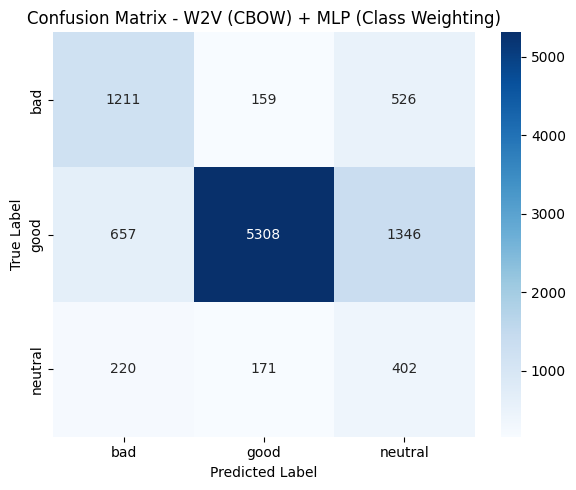

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test_raw, y_pred)
labels = label_encoder.classes_

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - W2V (CBOW) + MLP (Class Weighting)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [ ]:
# Import or initialize and train classifier
svm_weighted = SVM_training(X_train=X_train_cbow, y_train=y_train_raw, file_path=f"{directory_path}/svm_weighted_cbow.pkl")

# Predict
y_pred = svm_weighted.predict(X_test_cbow)

# Evaluate
print("SVM")
print(classification_report(y_test_raw, y_pred, target_names=label_encoder.classes_))

SVM already trained. Importing classifier..
SVM
              precision    recall  f1-score   support

         bad       0.59      0.69      0.63      1896
        good       0.89      0.88      0.88      7311
     neutral       0.23      0.14      0.18       793

    accuracy                           0.79     10000
   macro avg       0.57      0.57      0.56     10000
weighted avg       0.78      0.79      0.78     10000



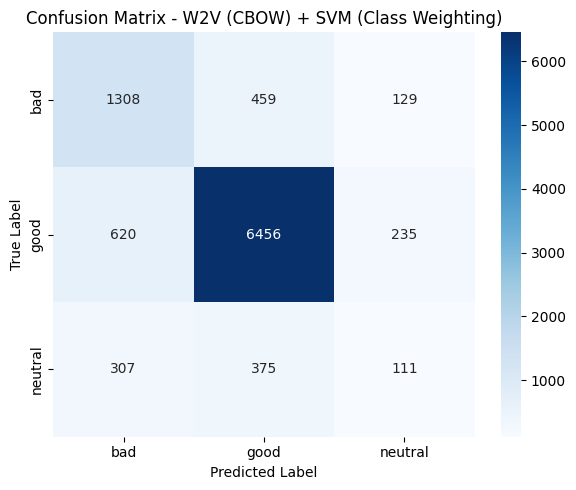

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test_raw, y_pred)
labels = label_encoder.classes_

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - W2V (CBOW) + SVM (Class Weighting)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

**Skip-Gram**


In [ ]:
# Load pipeline if exists
model_path = f"{directory_path}/torch_mlp_sg.pth"

# MLP
mlp = MLP_training(model_path, X_train_sg, y_train_raw, epochs=500, hidden_dim=100, lr=1e-3)

# Evaluate the model
mlp.eval()
X_test_tensor = torch.tensor(X_test_sg, dtype=torch.float32)

with torch.no_grad():
    logits = mlp(X_test_tensor)
    y_pred = torch.argmax(logits, dim=1).numpy()

print(classification_report(y_test_raw, y_pred, target_names=label_encoder.classes_))

TorchMLP found. Loading...
              precision    recall  f1-score   support

         bad       0.65      0.64      0.64      1896
        good       0.95      0.75      0.84      7311
     neutral       0.19      0.54      0.28       793

    accuracy                           0.71     10000
   macro avg       0.59      0.64      0.59     10000
weighted avg       0.83      0.71      0.76     10000



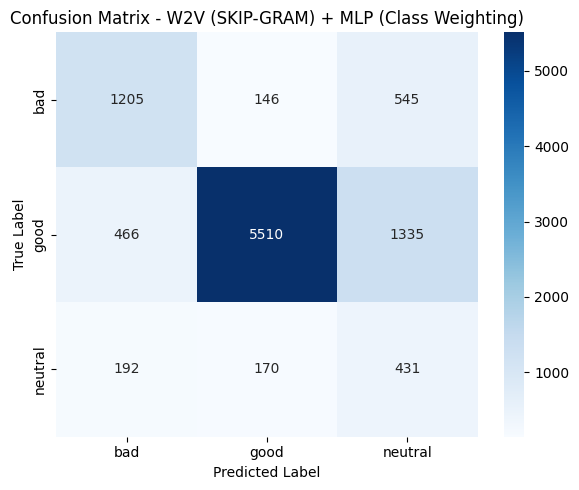

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test_raw, y_pred)
labels = label_encoder.classes_

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - W2V (SKIP-GRAM) + MLP (Class Weighting)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [ ]:
# Import or initialize and train classifier
svm_weighted = SVM_training(X_train=X_train_sg, y_train=y_train_raw, file_path=f"{directory_path}/svm_weighted_sg.pkl")

# Predict
y_pred = svm_weighted.predict(X_test_sg)

# Evaluate
print("SVM")
print(classification_report(y_test_raw, y_pred, target_names=label_encoder.classes_))

SVM already trained. Importing classifier..
SVM
              precision    recall  f1-score   support

         bad       0.64      0.71      0.68      1896
        good       0.90      0.90      0.90      7311
     neutral       0.28      0.19      0.23       793

    accuracy                           0.81     10000
   macro avg       0.61      0.60      0.60     10000
weighted avg       0.80      0.81      0.80     10000



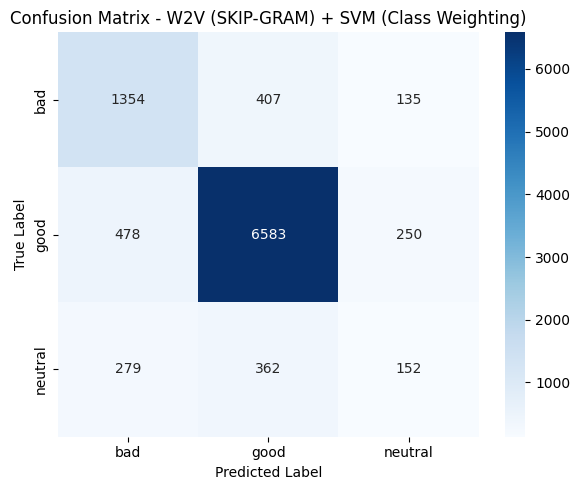

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test_raw, y_pred)
labels = label_encoder.classes_

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - W2V (SKIP-GRAM) + SVM (Class Weighting)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

Given that Word2Vec based on Skip-Gram performs better than that based on CBOW, train **LSTMs** (*forward* and *bidirectional*) on trained w2v embeddings:

In [ ]:
lengths = [len(l.split(' ')) for l in amazon_w2v.text]
print("Max length:", max(lengths))
print("95th percentile:", np.percentile(lengths, 90))
print("95th percentile:", np.percentile(lengths, 95))
print("Median length:", np.median(lengths))

Max length: 620
95th percentile: 37.0
95th percentile: 53.0
Median length: 10.0


In [ ]:
# LSTM
model_path = f"{directory_path}/lstm_weighted_sg.h5"
embedding_model = w2v_model_sg
max_num_words=50000
max_sequence_length=100

model = Train_LSTM_classifier(
    model_path=model_path,
    embedding_model=embedding_model,
    X_train_texts=X_train_texts,
    y_train_raw=y_train_raw,
    X_test_texts=X_test_texts,
    max_num_words=max_num_words,
    max_sequence_length=max_sequence_length,
    epochs=20,
    bidirectional=False,
    batch_size=32)

LSTM model already trained. Importing...


In [ ]:
# Create test set: tokenize with the same tokenizer used for training
tokenizer, X_train_, X_test = tokenize_lstm(X_train_texts, X_test_texts, max_num_words=max_num_words, max_sequence_length=max_sequence_length)
# Predict probabilities
y_pred_probs = model.predict(X_test)

# Convert to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Show classification report
print(classification_report(y_test_raw, y_pred, target_names=label_encoder.classes_))

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step
              precision    recall  f1-score   support

         bad       0.19      1.00      0.32      1896
        good       0.00      0.00      0.00      7311
     neutral       0.00      0.00      0.00       793

    accuracy                           0.19     10000
   macro avg       0.06      0.33      0.11     10000
weighted avg       0.04      0.19      0.06     10000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


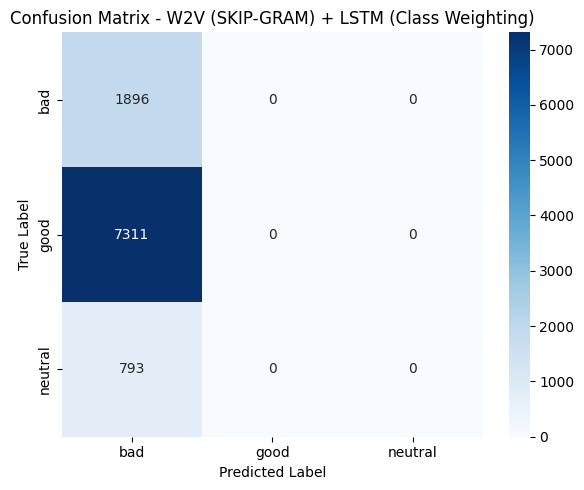

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test_raw, y_pred)
labels = label_encoder.classes_

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - W2V (SKIP-GRAM) + LSTM (Class Weighting)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [ ]:
# LSTM
model_path = f"{directory_path}/lstmbi_weighted_sg.h5"
embedding_model = w2v_model_sg
max_num_words=50000
max_sequence_length=100

model = Train_LSTM_classifier(
    model_path=model_path,
    embedding_model=embedding_model,
    X_train_texts=X_train_texts,
    y_train_raw=y_train_raw,
    X_test_texts=X_test_texts,
    max_num_words=max_num_words,
    max_sequence_length=max_sequence_length,
    epochs=20,
    bidirectional=True,
    batch_size=32)

LSTM model already trained. Importing...


In [ ]:
# Create test set: tokenize with the same tokenizer used for training
tokenizer, X_train_, X_test = tokenize_lstm(X_train_texts, X_test_texts, max_num_words=max_num_words, max_sequence_length=max_sequence_length)
# Predict probabilities
y_pred_probs = model.predict(X_test)

# Convert to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Show classification report
print(classification_report(y_test_raw, y_pred, target_names=label_encoder.classes_))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
              precision    recall  f1-score   support

         bad       0.00      0.00      0.00      1896
        good       0.73      1.00      0.84      7311
     neutral       0.00      0.00      0.00       793

    accuracy                           0.73     10000
   macro avg       0.24      0.33      0.28     10000
weighted avg       0.53      0.73      0.62     10000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


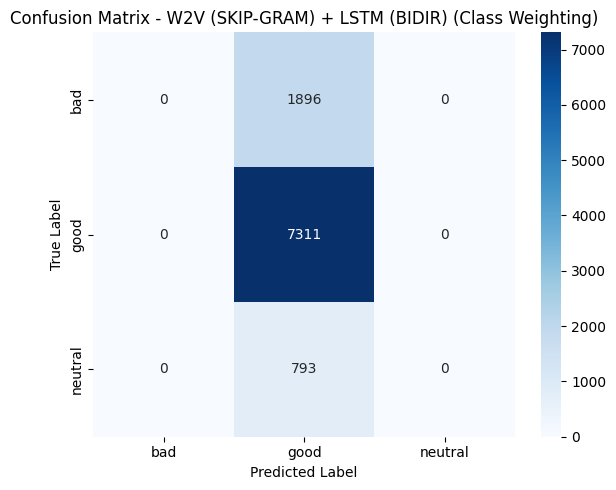

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test_raw, y_pred)
labels = label_encoder.classes_

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - W2V (SKIP-GRAM) + LSTM (BIDIR) (Class Weighting)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

The results, however, are not satisfactory: while some improvement was observed in certain classes (especially with Skip-Gram), overall performance remained lower than expected, particularly considering those observed with TF-IDF vectorization. This suggests that the learned embeddings did not provide sufficiently rich semantic representations for robust classification, which is expectable considering the small dimension of the dataset (due to limited computational resources).  

Given these results, it is preferable to proceed with a **pretrained GloVe model using a larger vocabulary** and potentially a broader context window. This would allow the embeddings to capture more semantic information and improve their usefulness for downstream classification tasks. Available Word2Vec pretrained models (like `word2vec-google-news-300`), are trained for other tasks, thus it could be useless in this context.

### **Pretrained Glove**

**GloVe (Global Vectors)** is another popular word embedding method. Unlike **Word2Vec**, which learns embeddings by predicting a word from its local context, GloVe is based on **matrix factorization of global word co-occurrence statistics** to encode both global statistics and local context information.  

Given the initial good performance with TF-IDF in predicting *good* and *bad* reviews, GloVe could be a good starting point of improvement.

In [ ]:
# Create a copy for recovery
amazon_glove = amazon_df.copy()

Given that the pretrained GloVe used is the `glove-twitter-100`, a good idea for the pre-processing part is to use the `TweetTokenizer`. Thus, define the pre-processing and tokenization function for GloVe (considering always that a pre-processing step has been done initially, during data cleaning phase), now keeping punctuation and emojis because GloVe's dictionary include them:

In [ ]:
# Tokenizer
tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

def glove_twitter_preprocess(text):
    # Remove hashtags symbol (#), keep the word
    text = re.sub(r"#", "", text)
    # Normalize spaces
    text = re.sub(r"\s+", " ", text).strip()
    # Tokenize like Twitter
    tokens = tweet_tokenizer.tokenize(text)
    return tokens   # <== return tokens

Apply on dataset:

In [ ]:
# Apply tfidf_preprocess
amazon_glove = amazon_glove.rename(columns={'text':'text_old'})
tqdm.pandas()
amazon_glove['text'] = amazon_glove['text_old'].progress_apply(lambda x: glove_twitter_preprocess(x))

  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
print('Before: ', amazon_glove.loc[0, 'text_old'])
print('After: ', amazon_glove.loc[0, 'text'])

Before:  I had dry hair, especially in this hot summer weather. I tried this for few days and all I can say is, &#34;goodbye dry hair&#34;! My hair became smoother and healthier. I tried different hair shampoos and conditioners before but the best one comes with the Argan Oil!
After:  ['i', 'had', 'dry', 'hair', ',', 'especially', 'in', 'this', 'hot', 'summer', 'weather', '.', 'i', 'tried', 'this', 'for', 'few', 'days', 'and', 'all', 'i', 'can', 'say', 'is', ',', 'goodbye', 'dry', 'hair', '!', 'my', 'hair', 'became', 'smoother', 'and', 'healthier', '.', 'i', 'tried', 'different', 'hair', 'shampoos', 'and', 'conditioners', 'before', 'but', 'the', 'best', 'one', 'comes', 'with', 'the', 'argan', 'oil', '!']


Split data into training and test sets and to get text representation with GloVe.

In [ ]:
# Preprocessed text and labels
texts = amazon_glove["text"].tolist()
labels = amazon_glove["vote"]

# Encode labels to integers
label_encoder = LabelEncoder()
y_all = label_encoder.fit_transform(labels)

# Split befor vectorization
X_train_texts, X_test_texts, y_train_raw, y_test_raw = train_test_split(
    texts, y_all,
    test_size=0.2,
    stratify=y_all,
    random_state=42)

Now, considering [gensim pretrained](https://radimrehurek.com/gensim/models/word2vec.html) models, use `glove-twitter-100` to get word embeddings.

In [ ]:
# Load GloVe
gloVe = gensim.downloader.load("glove-twitter-100")

[==================================================] 100.0% 387.1/387.1MB downloaded


In [ ]:
# Define vectorizer to vectorize the text data
def vectorize(tokens, model, vector_size):
    vecs = [model[w] for w in tokens if w in model]
    if not vecs:
        return np.zeros(vector_size)
    return np.mean(vecs, axis=0)

In [ ]:
# Convert all docs into vectors
X_train_glove = np.array([vectorize(tokens, gloVe, gloVe.vector_size)
                          for tokens in X_train_texts])
X_test_glove = np.array([vectorize(tokens, gloVe, gloVe.vector_size)
                         for tokens in X_test_texts])

Define model directory:

In [ ]:
# Directory path
directory_path = f"{recovery_dir}/GloVe"

In [ ]:
# Load pipeline if exists
model_path = f"{directory_path}/mlp_model_glove.pkl.pth"

# MLP
mlp = MLP_training(model_path, X_train_glove, y_train_raw, epochs=500, hidden_dim=100, lr=1e-3)

# Evaluate the model
mlp.eval()
X_test_tensor = torch.tensor(X_test_glove, dtype=torch.float32)

with torch.no_grad():
    logits = mlp(X_test_tensor)
    y_pred = torch.argmax(logits, dim=1).numpy()

print(classification_report(y_test_raw, y_pred, target_names=label_encoder.classes_))

TorchMLP found. Loading...
              precision    recall  f1-score   support

         bad       0.58      0.62      0.60      1896
        good       0.94      0.73      0.82      7311
     neutral       0.20      0.58      0.29       793

    accuracy                           0.70     10000
   macro avg       0.57      0.64      0.57     10000
weighted avg       0.82      0.70      0.74     10000



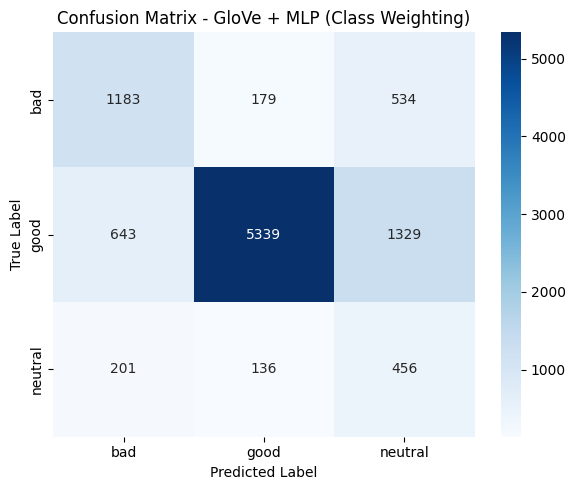

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test_raw, y_pred)
labels = label_encoder.classes_

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - GloVe + MLP (Class Weighting)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [ ]:
# Import or initialize and train classifier
svm_weighted = SVM_training(X_train=X_train_glove, y_train=y_train_raw, file_path=f"{directory_path}/svm_model_glove.pkl")

# Predict
y_pred = svm_weighted.predict(X_test_glove)

# Evaluate
print("SVM")
print(classification_report(y_test_raw, y_pred, target_names=label_encoder.classes_))

SVM already trained. Importing classifier..
SVM
              precision    recall  f1-score   support

         bad       0.59      0.66      0.63      1896
        good       0.88      0.88      0.88      7311
     neutral       0.24      0.18      0.20       793

    accuracy                           0.78     10000
   macro avg       0.57      0.57      0.57     10000
weighted avg       0.78      0.78      0.78     10000



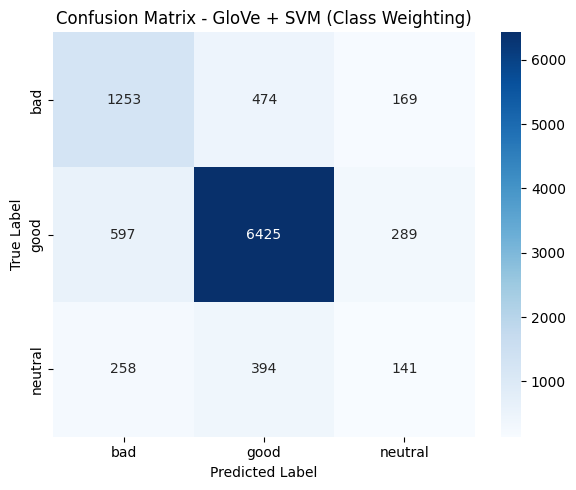

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test_raw, y_pred)
labels = label_encoder.classes_

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - GloVe + SVM (Class Weighting)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [ ]:
# LSTM
model_path = f"{directory_path}/lstm_weighted_glove.h5"
embedding_model = gloVe
max_num_words=50000
max_sequence_length=100

model = Train_LSTM_classifier(
    model_path=model_path,
    embedding_model=embedding_model,
    X_train_texts=X_train_texts,
    y_train_raw=y_train_raw,
    X_test_texts=X_test_texts,
    max_num_words=max_num_words,
    max_sequence_length=max_sequence_length,
    epochs=20,
    bidirectional=False,
    batch_size=128)

LSTM model already trained. Importing...


In [ ]:
# Create test set: tokenize with the same tokenizer used for training
tokenizer, X_train_, X_test = tokenize_lstm(X_train_texts, X_test_texts, max_num_words=max_num_words, max_sequence_length=max_sequence_length)
# Predict probabilities
y_pred_probs = model.predict(X_test)

# Convert to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Show classification report
print(classification_report(y_test_raw, y_pred, target_names=label_encoder.classes_))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

         bad       0.73      0.55      0.63      1896
        good       0.94      0.82      0.88      7311
     neutral       0.21      0.60      0.31       793

    accuracy                           0.75     10000
   macro avg       0.63      0.66      0.61     10000
weighted avg       0.85      0.75      0.79     10000



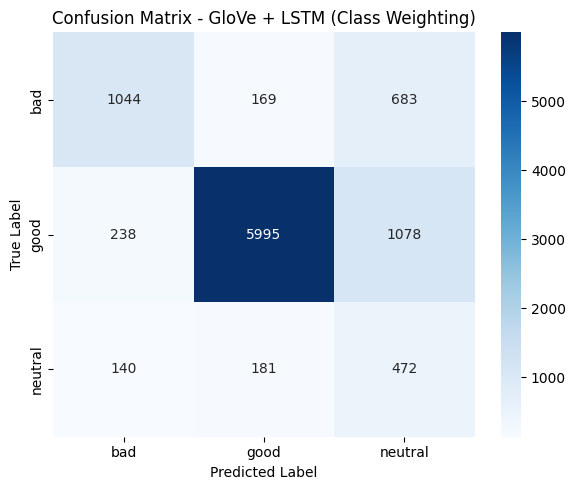

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test_raw, y_pred)
labels = label_encoder.classes_

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - GloVe + LSTM (Class Weighting)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [ ]:
# LSTM
model_path = f"{directory_path}/lstmbi_weighted_glove.h5"
embedding_model = gloVe
max_num_words=50000
max_sequence_length=100

model = Train_LSTM_classifier(
    model_path=model_path,
    embedding_model=embedding_model,
    X_train_texts=X_train_texts,
    y_train_raw=y_train_raw,
    X_test_texts=X_test_texts,
    max_num_words=max_num_words,
    max_sequence_length=max_sequence_length,
    epochs=20,
    bidirectional=True,
    batch_size=128)

LSTM model already trained. Importing...


In [ ]:
# Create test set: tokenize with the same tokenizer used for training
tokenizer, X_train_, X_test = tokenize_lstm(X_train_texts, X_test_texts, max_num_words=max_num_words, max_sequence_length=max_sequence_length)
# Predict probabilities
y_pred_probs = model.predict(X_test)

# Convert to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Show classification report
print(classification_report(y_test_raw, y_pred, target_names=label_encoder.classes_))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
              precision    recall  f1-score   support

         bad       0.77      0.60      0.67      1896
        good       0.96      0.81      0.87      7311
     neutral       0.22      0.65      0.32       793

    accuracy                           0.75     10000
   macro avg       0.65      0.68      0.62     10000
weighted avg       0.86      0.75      0.79     10000



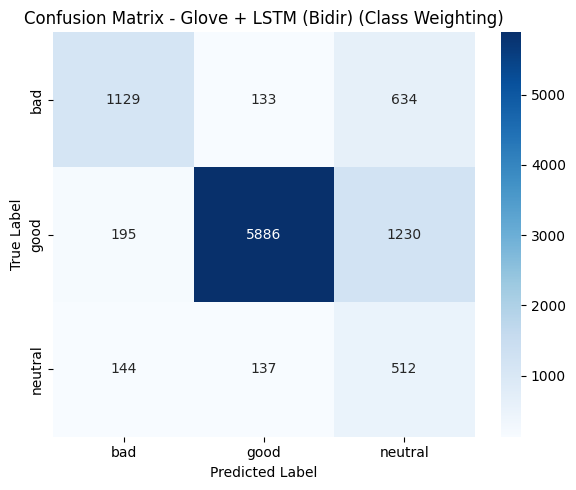

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test_raw, y_pred)
labels = label_encoder.classes_

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Glove + LSTM (Bidir) (Class Weighting)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

The experiments with **pretrained GloVe embeddings** show consistent performance across models, with SVM slightly outperforming MLP and LSTMs achieving comparable results.  
- SVM benefits from robust decision boundaries on fixed sentence embeddings.  
- LSTMs capture sequential dependencies, but the gains over simpler models remain limited.  
- The **neutral class** remains the most challenging across all setups, confirming the difficulty of modeling subtle sentiment with static embeddings.

Overall, results suggest that while GloVe embeddings provide a solid baseline, their **context-independent nature** constrains the models’ ability to generalize.  
This motivates moving to **FastText**, whose subword-level representations may better handle rare and morphologically rich words, potentially improving coverage and reducing misclassifications on underrepresented or ambiguous terms.


### **Fasttext**

**fastText** is an embedding model developed by Facebook that extends Word2Vec by representing words as bags of character n-grams.  
This allows it to generate vectors also for rare or unseen words and to capture morphological information.  

Compared to **Word2Vec** and **GloVe**, fastText can better handle out-of-vocabulary terms and inflected forms, making it particularly effective on noisy or morphologically rich text.

#### **Pretrained Fasttext**

As a first approach, try using a pre-trained Fasttext model to calculate the embeddings of each review.

In [ ]:
# Create a copy for recovery
amazon_ft = amazon_df.copy()

In [ ]:
def fasttext_preprocess(text):
    # Lowercase
    text = text.lower()
    # Normalize spaces
    text = re.sub(r"\s+", " ", text).strip()
    # Keep only alphabetic chars (remove digits, punctuation, emojis)
    text = re.sub(r"[^a-z\s]", " ", text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove empty tokens
    tokens = [t for t in tokens if t.strip() != ""]
    return tokens

Apply on dataset:

In [ ]:
# Apply fasttext_preprocess
amazon_ft = amazon_ft.rename(columns={'text':'text_old'})
tqdm.pandas()
amazon_ft['text'] = amazon_ft['text_old'].progress_apply(lambda x: fasttext_preprocess(x))

  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
print('Before: ', amazon_ft.loc[0, 'text_old'])
print('After: ', amazon_ft.loc[0, 'text'])

Before:  I had dry hair, especially in this hot summer weather. I tried this for few days and all I can say is, &#34;goodbye dry hair&#34;! My hair became smoother and healthier. I tried different hair shampoos and conditioners before but the best one comes with the Argan Oil!
After:  ['i', 'had', 'dry', 'hair', 'especially', 'in', 'this', 'hot', 'summer', 'weather', 'i', 'tried', 'this', 'for', 'few', 'days', 'and', 'all', 'i', 'can', 'say', 'is', 'goodbye', 'dry', 'hair', 'my', 'hair', 'became', 'smoother', 'and', 'healthier', 'i', 'tried', 'different', 'hair', 'shampoos', 'and', 'conditioners', 'before', 'but', 'the', 'best', 'one', 'comes', 'with', 'the', 'argan', 'oil']


Split data into training and test sets and to get text representation.

In [ ]:
# Preprocessed text and labels
texts = amazon_ft["text"].tolist()
labels = amazon_ft["vote"]

# Encode labels to integers
label_encoder = LabelEncoder()
y_all = label_encoder.fit_transform(labels)

# Split befor vectorization
X_train_texts, X_test_texts, y_train_raw, y_test_raw = train_test_split(
    texts, y_all,
    test_size=0.2,
    stratify=y_all,
    random_state=42)

Try to use `fasttext-wiki-news-subwords-300` to get word embeddings.

In [ ]:
# Load pretrained FastText (wiki-news)
fasttext_model = gensim.downloader.load("fasttext-wiki-news-subwords-300")

[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
# Directory path
directory_path = f"{recovery_dir}/Fasttext"

In [ ]:
# Define vectorizer to vectorize the text data
def vectorize(tokens, model, vector_size):
    vecs = [model[w] for w in tokens if w in model]
    if not vecs:
        return np.zeros(vector_size)
    return np.mean(vecs, axis=0)

In [ ]:
# Convert all docs into vectors
X_train_ft = np.array([vectorize(tokens, fasttext_model, fasttext_model.vector_size)
                       for tokens in X_train_texts])
X_test_ft = np.array([vectorize(tokens, fasttext_model, fasttext_model.vector_size)
                      for tokens in X_test_texts])

In [ ]:
# Load pipeline if exists
model_path = f"{directory_path}/mlp_model_ft.pkl.pth"

# MLP
mlp = MLP_training(model_path, X_train_ft, y_train_raw, epochs=300, hidden_dim=300, lr=1e-3)

# Evaluate the model
mlp.eval()
X_test_tensor = torch.tensor(X_test_ft, dtype=torch.float32)

with torch.no_grad():
    logits = mlp(X_test_tensor)
    y_pred = torch.argmax(logits, dim=1).numpy()

print(classification_report(y_test_raw, y_pred, target_names=label_encoder.classes_))

TorchMLP found. Loading...
              precision    recall  f1-score   support

         bad       0.64      0.67      0.66      1896
        good       0.96      0.76      0.84      7311
     neutral       0.21      0.58      0.31       793

    accuracy                           0.73     10000
   macro avg       0.60      0.67      0.60     10000
weighted avg       0.84      0.73      0.77     10000



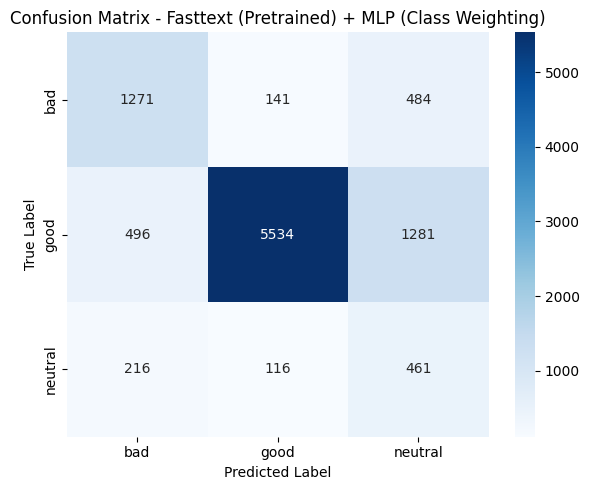

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test_raw, y_pred)
labels = label_encoder.classes_

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Fasttext (Pretrained) + MLP (Class Weighting)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [ ]:
# Import or initialize and train classifier
svm_weighted = SVM_training(X_train=X_train_ft, y_train=y_train_raw, file_path=f"{directory_path}/svm_model_ft.pkl")

# Predict
y_pred = svm_weighted.predict(X_test_ft)

# Evaluate
print("SVM")
print(classification_report(y_test_raw, y_pred, target_names=label_encoder.classes_))

SVM already trained. Importing classifier..
SVM
              precision    recall  f1-score   support

         bad       0.66      0.70      0.68      1896
        good       0.90      0.90      0.90      7311
     neutral       0.29      0.25      0.27       793

    accuracy                           0.81     10000
   macro avg       0.62      0.62      0.62     10000
weighted avg       0.81      0.81      0.81     10000



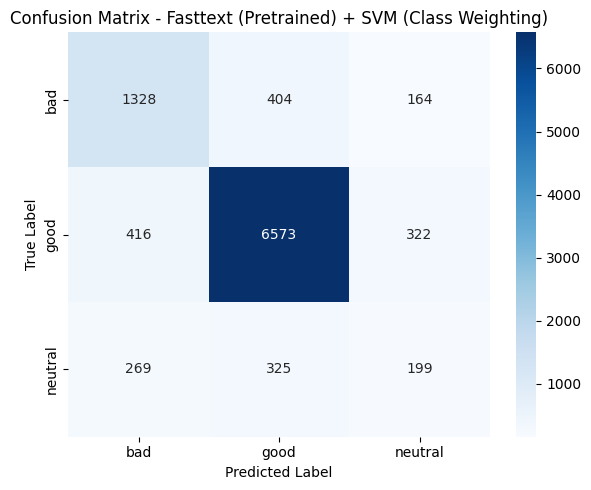

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test_raw, y_pred)
labels = label_encoder.classes_

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Fasttext (Pretrained) + SVM (Class Weighting)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [ ]:
# LSTM
model_path = f"{directory_path}/lstm_weighted_fasttext.h5"
embedding_model = fasttext_model
max_num_words=50000
max_sequence_length=100

model = Train_LSTM_classifier(
    model_path=model_path,
    embedding_model=embedding_model,
    X_train_texts=X_train_texts,
    y_train_raw=y_train_raw,
    X_test_texts=X_test_texts,
    max_num_words=max_num_words,
    max_sequence_length=max_sequence_length,
    epochs=20,
    bidirectional=False,
    batch_size=128)

LSTM model already trained. Importing...


In [ ]:
# Create test set: tokenize with the same tokenizer used for training
tokenizer, X_train_, X_test = tokenize_lstm(X_train_texts, X_test_texts, max_num_words=max_num_words, max_sequence_length=max_sequence_length)
# Predict probabilities
y_pred_probs = model.predict(X_test)

# Convert to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Show classification report
print(classification_report(y_test_raw, y_pred, target_names=label_encoder.classes_))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

         bad       0.75      0.65      0.70      1896
        good       0.96      0.79      0.87      7311
     neutral       0.21      0.60      0.31       793

    accuracy                           0.75     10000
   macro avg       0.64      0.68      0.62     10000
weighted avg       0.86      0.75      0.79     10000



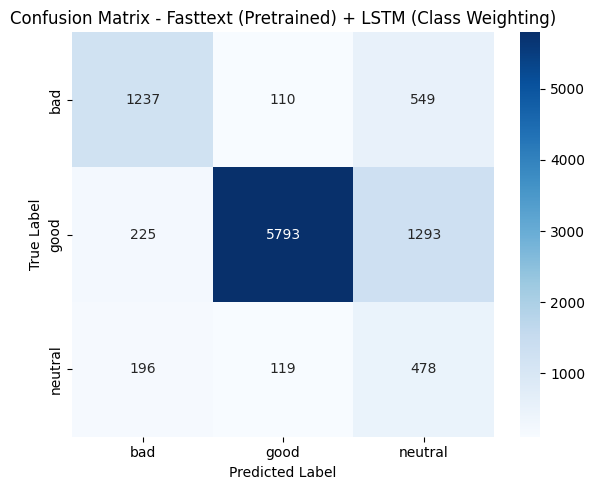

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test_raw, y_pred)
labels = label_encoder.classes_

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Fasttext (Pretrained) + LSTM (Class Weighting)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [ ]:
# LSTM
model_path = f"{directory_path}/lstmbi_weighted_fasttext.h5"
embedding_model = fasttext_model
max_num_words=50000
max_sequence_length=100

model = Train_LSTM_classifier(
    model_path=model_path,
    embedding_model=embedding_model,
    X_train_texts=X_train_texts,
    y_train_raw=y_train_raw,
    X_test_texts=X_test_texts,
    max_num_words=max_num_words,
    max_sequence_length=max_sequence_length,
    epochs=20,
    bidirectional=True,
    batch_size=128)

LSTM model already trained. Importing...


In [ ]:
# Create test set: tokenize with the same tokenizer used for training
tokenizer, X_train_, X_test = tokenize_lstm(X_train_texts, X_test_texts, max_num_words=max_num_words, max_sequence_length=max_sequence_length)
# Predict probabilities
y_pred_probs = model.predict(X_test)

# Convert to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Show classification report
print(classification_report(y_test_raw, y_pred, target_names=label_encoder.classes_))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
              precision    recall  f1-score   support

         bad       0.71      0.72      0.72      1896
        good       0.95      0.85      0.90      7311
     neutral       0.24      0.48      0.32       793

    accuracy                           0.79     10000
   macro avg       0.64      0.68      0.65     10000
weighted avg       0.85      0.79      0.82     10000



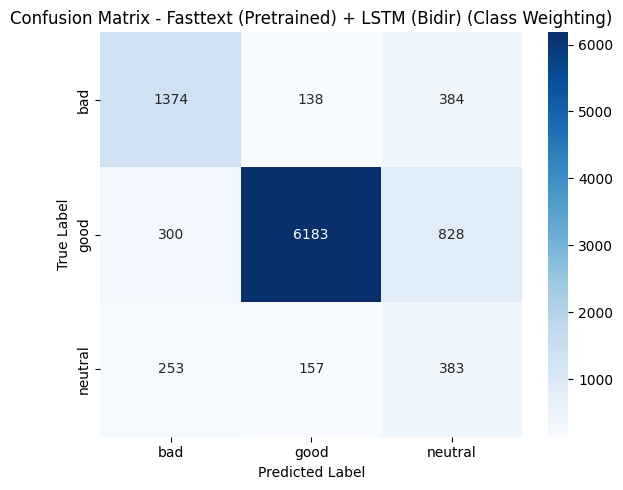

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test_raw, y_pred)
labels = label_encoder.classes_

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Fasttext (Pretrained) + LSTM (Bidir) (Class Weighting)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

It appears that using pre-trained Fasttext led the classifier to achieve performance in line with that of SVM trained on TF-IDF, with slightly better results on neutral reviews. So, it's a good starting point!

The reason why, despite the power of the model, the results are not significantly better than previous approaches is probably because the **model available** has **not been trained on informal language**, potentially influenced by slang, which is typical of reviews.

#### **Fasttext Unsupervised and Supervised**

Another approach is to proceed with **unsupervised training** of Fasttext on the dataset, to get better and adapted word representations based on the dataset, instead of using a pre-trained model. Moreover, it is possible to train a **supervised** fasttext. However, for this last one, it is necessary to apply re-sampling techniques: this solution doesn't match perfectly the class weighting approach adopted up to now, but it's the only way to handle this problem.

In [ ]:
# Preprocessing
def basic_clean(text):
    text = str(text).lower()
    text = re.sub(r"<.*?>", " ", text)                    # remove HTML
    text = re.sub(r"http\S+|www\S+|https\S+", " ", text)  # remove URLs
    text = re.sub(r"[^a-z\s]", " ", text)                 # keep only a-z letters
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Train/Test split
amazon_ft_unsup = amazon_df.copy()
amazon_ft_unsup = amazon_ft_unsup.rename(columns={'text':'text_old'})
tqdm.pandas()
amazon_ft_unsup["text"] = amazon_ft_unsup["text_old"].progress_apply(basic_clean)

X = amazon_ft_unsup["text"].tolist()
y = amazon_ft_unsup["vote"].tolist()

# Encode labels (sklearn classifier needs ints)
label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

# Decode labels back to strings for fastText supervised
y_train_str = label_encoder.inverse_transform(y_train)
y_test_str = label_encoder.inverse_transform(y_test)

  0%|          | 0/50000 [00:00<?, ?it/s]

Balance data only for the **supervised** approach:

In [ ]:
# Balance data
counts = Counter(y_train_str)
print("Class distribution before:", counts)

# Select a fixed dimension
target_count = 7000

# Balance training set
balanced_train = []
for label in counts:
    class_reviews = [t for t, l in zip(X_train, y_train_str) if l == label]

    if len(class_reviews) > target_count:
        # undersampling
        sampled = random.sample(class_reviews, target_count)
    else:
        # oversampling
        sampled = random.choices(class_reviews, k=target_count)

    balanced_train.extend([(r, label) for r in sampled])

print("Class distribution after:", Counter([l for _, l in balanced_train]))

Class distribution before: Counter({'good': 29244, 'bad': 7585, 'neutral': 3171})
Class distribution after: Counter({'good': 7000, 'bad': 7000, 'neutral': 7000})


In [ ]:
# Create txt files
# Unsupervised embeddings file
if not os.path.exists(f"{recovery_dir}/Fasttext/reviews.txt"):
  with open(f"{recovery_dir}/Fasttext/reviews.txt", "w", encoding="utf-8") as f:
      for review in X_train:  # only training reviews
          f.write(review + "\n")

# Supervised train/test files (next step)
if not os.path.exists(f"{recovery_dir}/Fasttext/train.txt"):
  with open(f"{recovery_dir}/Fasttext/train.txt", "w", encoding="utf-8") as f:
      for review, label in balanced_train:
          f.write(f"__label__{label} {review}\n")

if not os.path.exists(f"{recovery_dir}/Fasttext/test.txt"):
  with open(f"{recovery_dir}/Fasttext/test.txt", "w", encoding="utf-8") as f:
      for review, label in zip(X_test, y_test_str):
          f.write(f"__label__{label} {review}\n")

Apply **unsupervised fasttext** for learning text representations:

In [ ]:
# Train FastText embeddings (unsupervised, skipgram)
if not os.path.exists(f"{recovery_dir}/Fasttext/amazon_ft_unsup.bin"):
  ft_unsup = fasttext.train_unsupervised(f"{recovery_dir}/Fasttext/reviews.txt", model="skipgram", dim=100, epoch=10, minCount=5)
  ft_unsup.save_model(f"{recovery_dir}/Fasttext/amazon_ft_unsup.bin")
else:
  ft_unsup = fasttext.load_model(f"{recovery_dir}/Fasttext/amazon_ft_unsup.bin")

# Vectorize documents (average of word vectors)
def vectorize_doc(text, model):
    tokens = text.split()
    vecs = [model.get_word_vector(w) for w in tokens if w.strip() != ""]
    if not vecs:
        return np.zeros(model.get_dimension())
    return np.mean(vecs, axis=0)

X_train_vec = np.array([vectorize_doc(t, ft_unsup) for t in X_train])
X_test_vec  = np.array([vectorize_doc(t, ft_unsup) for t in X_test])

In [ ]:
# Load pipeline if exists
model_path = f"{directory_path}/mlp_model_ft_unusp.pkl.pth"

# MLP
mlp = MLP_training(model_path, X_train_vec, y_train_raw, epochs=300, hidden_dim=100, lr=1e-3)

# Evaluate the model
mlp.eval()
X_test_tensor = torch.tensor(X_test_vec, dtype=torch.float32)

with torch.no_grad():
    logits = mlp(X_test_tensor)
    y_pred = torch.argmax(logits, dim=1).numpy()

print(classification_report(y_test_raw, y_pred, target_names=label_encoder.classes_))

TorchMLP found. Loading...
              precision    recall  f1-score   support

         bad       0.68      0.69      0.69      1896
        good       0.96      0.77      0.85      7311
     neutral       0.21      0.59      0.31       793

    accuracy                           0.74     10000
   macro avg       0.62      0.68      0.62     10000
weighted avg       0.85      0.74      0.78     10000



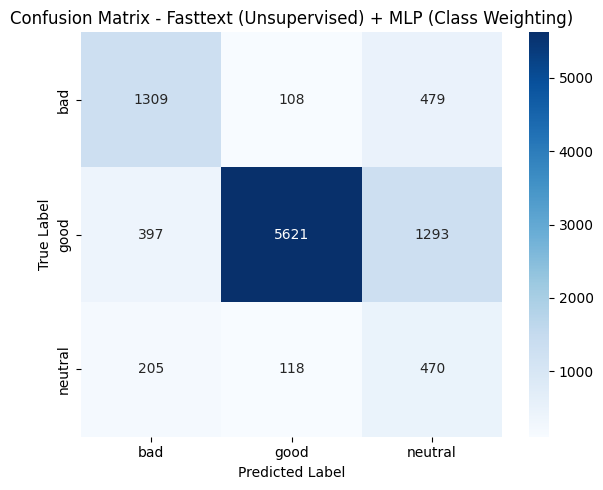

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test_raw, y_pred)
labels = label_encoder.classes_

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Fasttext (Unsupervised) + MLP (Class Weighting)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [ ]:
# Import or initialize and train classifier
svm_weighted = SVM_training(X_train=X_train_vec, y_train=y_train_raw, file_path=f"{directory_path}/svm_model_ft_unusp.pkl")

# Predict
y_pred = svm_weighted.predict(X_test_vec)

# Evaluate
print("SVM")
print(classification_report(y_test_raw, y_pred, target_names=label_encoder.classes_))

SVM already trained. Importing classifier..
SVM
              precision    recall  f1-score   support

         bad       0.68      0.75      0.71      1896
        good       0.91      0.91      0.91      7311
     neutral       0.28      0.23      0.25       793

    accuracy                           0.82     10000
   macro avg       0.62      0.63      0.62     10000
weighted avg       0.82      0.82      0.82     10000



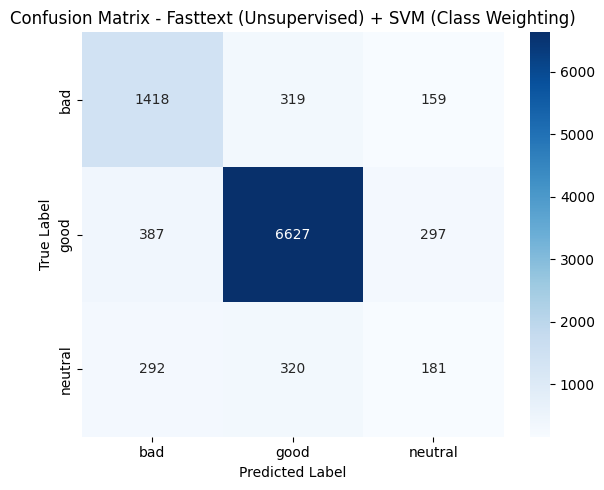

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test_raw, y_pred)
labels = label_encoder.classes_

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Fasttext (Unsupervised) + SVM (Class Weighting)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [ ]:
# LSTM
model_path = f"{directory_path}/lstm_weighted_fasttext_unsup.h5"
embedding_model = ft_unsup
max_num_words=50000
max_sequence_length=100

model = Train_LSTM_classifier(
    model_path=model_path,
    embedding_model=embedding_model,
    X_train_texts=X_train,
    y_train_raw=y_train,
    X_test_texts=X_test,
    max_num_words=max_num_words,
    max_sequence_length=max_sequence_length,
    epochs=20,
    bidirectional=False,
    batch_size=128)

LSTM model already trained. Importing...


In [ ]:
# Create test set: tokenize with the same tokenizer used for training
tokenizer, X_train_, X_test = tokenize_lstm(X_train, X_test, max_num_words=max_num_words, max_sequence_length=max_sequence_length)
# Predict probabilities
y_pred_probs = model.predict(X_test)

# Convert to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Show classification report
print(classification_report(y_test_raw, y_pred, target_names=label_encoder.classes_))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

         bad       0.75      0.63      0.69      1896
        good       0.94      0.86      0.90      7311
     neutral       0.23      0.51      0.32       793

    accuracy                           0.79     10000
   macro avg       0.64      0.67      0.63     10000
weighted avg       0.85      0.79      0.81     10000



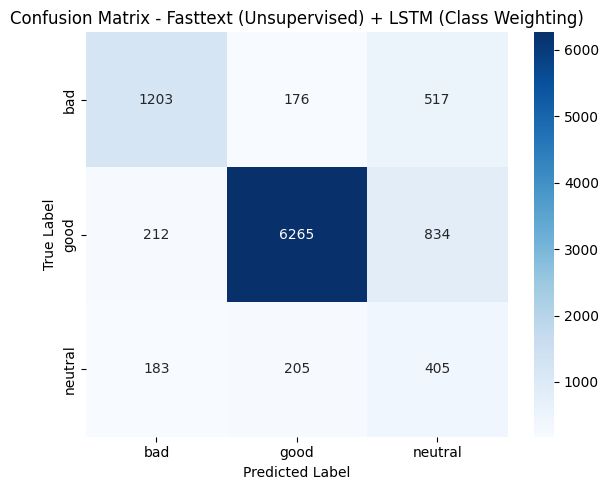

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = label_encoder.classes_

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Fasttext (Unsupervised) + LSTM (Class Weighting)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [ ]:
# LSTM
model_path = f"{directory_path}/lstmbi_weighted_fasttext_unsup.h5"
embedding_model = ft_unsup
max_num_words=50000
max_sequence_length=100

model = Train_LSTM_classifier(
    model_path=model_path,
    embedding_model=embedding_model,
    X_train_texts=X_train,
    y_train_raw=y_train,
    X_test_texts=X_test,
    max_num_words=max_num_words,
    max_sequence_length=max_sequence_length,
    epochs=20,
    bidirectional=True,
    batch_size=128)

LSTM model already trained. Importing...


In [ ]:
# Create test set: tokenize with the same tokenizer used for training
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)
tokenizer, X_train, X_test = tokenize_lstm(X_train, X_test, max_num_words=max_num_words, max_sequence_length=max_sequence_length)
# Predict probabilities
y_pred_probs = model.predict(X_test)

# Convert to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Show classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
              precision    recall  f1-score   support

         bad       0.73      0.72      0.72      1896
        good       0.96      0.82      0.89      7311
     neutral       0.23      0.55      0.32       793

    accuracy                           0.78     10000
   macro avg       0.64      0.70      0.64     10000
weighted avg       0.86      0.78      0.81     10000



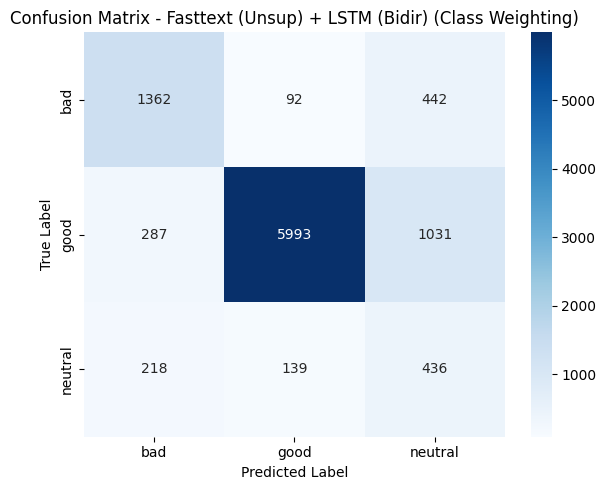

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test_raw, y_pred)
labels = label_encoder.classes_

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Fasttext (Unsup) + LSTM (Bidir) (Class Weighting)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

Although still rather weak on the neutral class, the results are improved compared to the use of the pre-trained model: negative reviews have an F1 score in line with that obtained by applying TF-IDF, positive reviews continue to perform well and neutral reviews still perform rather disappointingly but have improved significantly.

One of the problems is that the training set contains about 40k reviews, and a larger dataset would probably be necessary (due to limited computational resources, it was not possible to opt for another solution).

However, the fact remains that the reviews also contain a description of the product, so many words may be irrelevant and generate noise, obscuring semantics that contrast negative and positive aspects, leading the user to a neutral review.

For this reason, more complex models capable to catch deep semantics are needed.

Finally, test **supervised Fasttext** which can be used to directly classify reviews:

In [ ]:
# Train fastText supervised classifier
if not os.path.exists(f"{directory_path}/amazon_ft_supervised.bin"):
  print('Training model:')
  ft_sup = fasttext.train_supervised(input=f"{directory_path}/train.txt", epoch=200, lr=0.05, dim=300, minCount=3, wordNgrams=2, loss="ova")
  ft_sup.save_model(f"{directory_path}/amazon_ft_supervised.bin")
else:
  print('Importing model:')
  ft_sup = fasttext.load_model(f"{directory_path}/amazon_ft_supervised.bin")

# Evaluate on test set
print("FastText raw test():", ft_sup.test(f"{directory_path}/test.txt"))  # (n_samples, precision@1, recall@1)

# More detailed evaluation with sklearn
y_true = y_test_str
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)
preds = [ft_sup.predict(t)[0][0].replace("__label__","") for t in X_test]

print(classification_report(y_true, preds))
print(confusion_matrix(y_true, preds))

Importing model:
FastText raw test(): (10000, 0.6816, 0.6816)
              precision    recall  f1-score   support

         bad       0.43      0.50      0.46      1896
        good       0.94      0.74      0.83      7311
     neutral       0.22      0.57      0.32       793

    accuracy                           0.68     10000
   macro avg       0.53      0.60      0.54     10000
weighted avg       0.79      0.68      0.72     10000

[[ 953  148  795]
 [1096 5413  802]
 [ 175  168  450]]


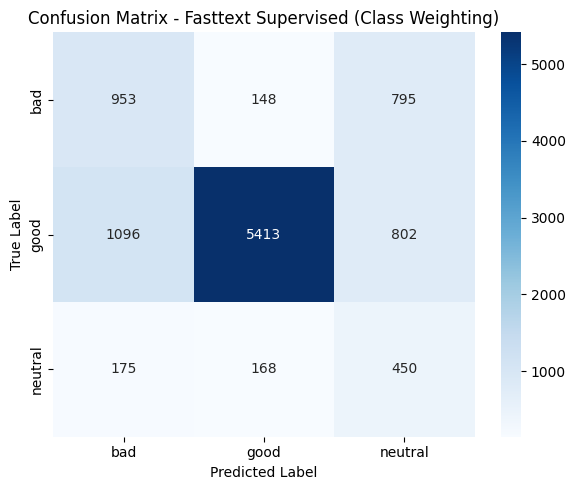

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, preds)
labels = label_encoder.classes_

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Fasttext Supervised (Class Weighting)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

Supervised **fastText** underperforms probably because it relies on a simple linear classifier, and requires very large datasets to learn both embeddings and classifier jointly, which is not possible considering the dimension of the training set.  

By contrast, learning embeddings **unsupervised** on the review corpus first captures domain-specific semantics and then applying stronger classifiers allows more flexible decision boundaries.  

### **Sentence-Transformer**

Before applying **DistilBERT directly as a classifier**, it is useful to test a lighter approach with **[Sentence-BERT](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) embeddings combined with classifiers**.  

Sentence-BERT produces semantically meaningful sentence-level embeddings that can be fed into traditional classifiers such as SVM or MLP. This setup allows to evaluate the effectiveness of contextualized representations without the full computational cost of fine-tuning a transformer-based model end-to-end.



In [ ]:
# Create a copy of the dataset
amazon_st = amazon_df.copy()

In [ ]:
# Cleaning function for BERT
def clean_for_st(text):
    text = text.lower()  # lowercase
    text = re.sub(r"http\S+", " ", text)  # remove URLs
    text = re.sub(r"\d+", " ", text)      # remove numbers
    text = text.translate(str.maketrans("", "", string.punctuation))  # remove punctuation
    text = re.sub(r"\s+", " ", text).strip()  # remove extra spaces
    return text

In [ ]:
# Rename and preprocess
amazon_st = amazon_st.rename(columns={'text':'text_old'})
tqdm.pandas()
amazon_st['text'] = amazon_st['text_old'].progress_apply(lambda x: clean_for_st(x))

  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
# Prepare dataset
texts = amazon_st["text"].tolist()
labels = amazon_st["vote"].tolist()

# Encode labels
label_encoder = LabelEncoder()
labels_enc = label_encoder.fit_transform(labels)

# Train/test split with stratification (important for unbalanced classes)
X_train, X_test, y_train, y_test = train_test_split(texts, labels_enc, test_size=0.2, stratify=labels_enc, random_state=42)

Apply Sentence BERT to get sentence embeddings. Save for recovery data to save computational resources for future run:

In [ ]:
# Define files' path
embed_dir = f"{recovery_dir}/SBERT"
os.makedirs(embed_dir, exist_ok=True)

train_emb_path = os.path.join(embed_dir, "X_train_emb.npy")
test_emb_path = os.path.join(embed_dir, "X_test_emb.npy")

In [ ]:
# Get sentence embeddings
if os.path.exists(train_emb_path) and os.path.exists(test_emb_path):
    print("Loading precomputed embeddings...")
    X_train_emb = np.load(train_emb_path)
    X_test_emb = np.load(test_emb_path)
else:
    print("Computing embeddings with BERT...")
    model = SentenceTransformer("all-MiniLM-L6-v2", device="cuda" if torch.cuda.is_available() else "cpu")
    X_train_emb = model.encode(X_train, batch_size=32, show_progress_bar=True)
    X_test_emb = model.encode(X_test, batch_size=32, show_progress_bar=True)
    np.save(train_emb_path, X_train_emb)
    np.save(test_emb_path, X_test_emb)
    print("Embeddings saved in", embed_dir)

Loading precomputed embeddings...


In [ ]:
# Directory path
directory_path = embed_dir

In [ ]:
# Load pipeline if exists
model_path = f"{directory_path}/mlp_model_sbert.pkl.pth"

# MLP
mlp = MLP_training(model_path, X_train_emb, y_train, epochs=300, hidden_dim=300, lr=1e-3)

# Evaluate the model
mlp.eval()
X_test_tensor = torch.tensor(X_test_emb, dtype=torch.float32)

with torch.no_grad():
    logits = mlp(X_test_tensor)
    y_pred = torch.argmax(logits, dim=1).numpy()

print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

TorchMLP found. Loading...
              precision    recall  f1-score   support

         bad       0.64      0.71      0.67      1896
        good       0.95      0.78      0.86      7311
     neutral       0.21      0.50      0.30       793

    accuracy                           0.75     10000
   macro avg       0.60      0.66      0.61     10000
weighted avg       0.83      0.75      0.78     10000



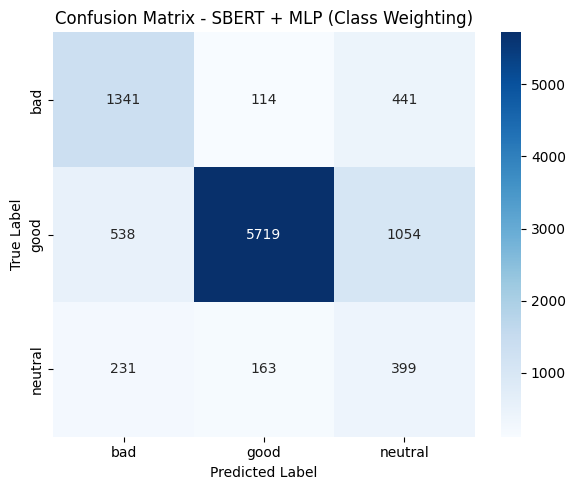

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = label_encoder.classes_

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - SBERT + MLP (Class Weighting)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [ ]:
# Import or initialize and train classifier
svm_weighted = SVM_training(X_train=X_train_emb, y_train=y_train, file_path=f"{directory_path}/svm_model_sbert.pkl")

# Predict
y_pred = svm_weighted.predict(X_test_emb)

# Evaluate
print("SVM")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

SVM already trained. Importing classifier..
SVM
              precision    recall  f1-score   support

         bad       0.67      0.75      0.71      1896
        good       0.91      0.90      0.91      7311
     neutral       0.30      0.25      0.27       793

    accuracy                           0.82     10000
   macro avg       0.63      0.63      0.63     10000
weighted avg       0.82      0.82      0.82     10000



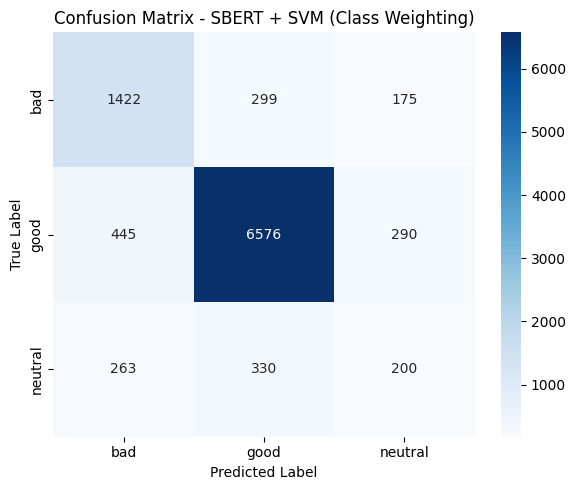

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = label_encoder.classes_

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - SBERT + SVM (Class Weighting)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

The experiments with **Sentence-BERT embeddings** combined with SVM and MLP confirm the benefit of using contextualized representations.  
- Performance is generally higher than with static embeddings (e.g., GloVe) and comparable to the best FastText setups.  
- SVM once again provides the strongest results, suggesting that sentence-level embeddings pair well with linear decision boundaries.  
- MLP shows competitive performance, though slightly lower than SVM.  

Overall, Sentence-BERT offers a **good trade-off between accuracy and efficiency**: it improves over static embeddings without requiring full transformer fine-tuning, making it a suitable intermediate step before testing DistilBERT as a classifier.

### **DistilBERT Fine-Tuning**

Finally apply **DistilBERT**: the application of this model is a supervised approach to fine-tune embeddings, specifically for this context, and learn to correctly classify reviews.

In [ ]:
# Create a copy of the dataset
amazon_bert = amazon_df.copy()

In [ ]:
def clean_for_bert(text):
    text = str(text)
    # Decode HTML entities (e.g., &#34; → ")
    text = html.unescape(text)
    # Remove HTML tags
    text = re.sub(r"<.*?>", " ", text)
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", " ", text)
    # Normalize spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

Apply on dataset:

In [ ]:
# Apply fasttext_preprocess
amazon_bert = amazon_bert.rename(columns={'text':'text_old'})
tqdm.pandas()
amazon_bert['text'] = amazon_bert['text_old'].progress_apply(lambda x: clean_for_bert(x))

  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
print('Before: ', amazon_bert.loc[0, 'text_old'])
print('After: ', amazon_bert.loc[0, 'text'])

Before:  I had dry hair, especially in this hot summer weather. I tried this for few days and all I can say is, &#34;goodbye dry hair&#34;! My hair became smoother and healthier. I tried different hair shampoos and conditioners before but the best one comes with the Argan Oil!
After:  I had dry hair, especially in this hot summer weather. I tried this for few days and all I can say is, "goodbye dry hair"! My hair became smoother and healthier. I tried different hair shampoos and conditioners before but the best one comes with the Argan Oil!


In [ ]:
# Dataset preparation
texts = amazon_bert["text"].tolist()
labels = amazon_bert["vote"].tolist()

# Encode labels
label_encoder = LabelEncoder()
labels_enc = label_encoder.fit_transform(labels)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(texts, labels_enc, test_size=0.2, stratify=labels_enc, random_state=42)

Define directory path to save model:

In [ ]:
save_dir = f"{recovery_dir}/DistilBERT"

Now define both tokenizer and model:

In [ ]:
# Tokenizer and model
num_labels = len(label_encoder.classes_)
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Check if GPU is available:

In [ ]:
if torch.cuda.is_available():
    print("CUDA available")
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("Running on CPU")

CUDA available
GPU name: Tesla T4


Check how the tokenizer works:

In [ ]:
# Tokenization
encoding_ex = tokenizer(
    amazon_bert.loc[0, 'text'],
    truncation=True,
    padding="max_length",
    max_length=100,  # reduce the length only for the example
    return_tensors="pt"
)

# Show tokens as strings
tk_ex = tokenizer.convert_ids_to_tokens(encoding_ex["input_ids"][0])

print("Tokens:", tk_ex)
print("Token IDs:", encoding_ex["input_ids"][0].tolist())

Tokens: ['[CLS]', 'i', 'had', 'dry', 'hair', ',', 'especially', 'in', 'this', 'hot', 'summer', 'weather', '.', 'i', 'tried', 'this', 'for', 'few', 'days', 'and', 'all', 'i', 'can', 'say', 'is', ',', '"', 'goodbye', 'dry', 'hair', '"', '!', 'my', 'hair', 'became', 'smooth', '##er', 'and', 'health', '##ier', '.', 'i', 'tried', 'different', 'hair', 'sham', '##poo', '##s', 'and', 'condition', '##ers', 'before', 'but', 'the', 'best', 'one', 'comes', 'with', 'the', 'ar', '##gan', 'oil', '!', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Token IDs: [101, 1045, 2018, 4318, 2606, 1010, 2926, 1999, 2023, 2980, 2621, 4633, 1012, 1045, 2699, 2023, 2005, 2261, 2420, 1998, 2035, 1045, 2064, 2360, 2003, 1010, 1000, 911

The DistilBERT tokenizer works with a **WordPiece subword vocabulary**. It splits text into tokens that may be whole words (*hair*), punctuation marks (*","*),  or subwords marked with `##` (*smooth##er*, *health##ier*). This allows the model to handle rare words by decomposing them into known sub-components.  

Special tokens are also added:  
- `[CLS]` at the start (used for classification tasks)  
- `[SEP]` at the end (to separate sequences)  
- `[PAD]` tokens to ensure fixed sequence length  

Each token is then mapped to an integer ID (e.g., `[CLS] → 101`, `"hair" → 2606`), which is the actual input to the model.  

In [ ]:
# Define the average sentence length
lengths = [len(tokenizer.encode(t, truncation=False)) for t in amazon_bert["text"]]

Token indices sequence length is longer than the specified maximum sequence length for this model (671 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
print("Max length:", max(lengths))
print("95th percentile:", np.percentile(lengths, 90))
print("95th percentile:", np.percentile(lengths, 95))
print("Median length:", np.median(lengths))

Max length: 1428
95th percentile: 95.0
95th percentile: 137.0
Median length: 27.0


This check was necessary to determine the distribution of review lengths within the dataset. This is necessary because, when training the model, vectors must be of the same length, so it is necessary to specify the **maximum length** (therefore, in the case of shorter reviews, padding is applied, as already shown in the example above).

Common lengths chosen are 128 or 256, but the longer the vectors, the longer the training time.
However, looking at the distribution of lengths, it's possible to see that more than 90% of reviews are shorter than 128 tokens, so the amount of information that would be lost by truncating reviews to 128 tokens would be reduced.

In [ ]:
# Define global settings
MAX_LEN = 128       # max sequence length for tokenizer (try 128 or 256)
BATCH_SIZE = 32     # batch size for DataLoader (reduce if GPU runs out of memory)
EPOCHS = 3          # training epochs
LR = 2e-5           # learning rate

In [ ]:
# Create a custom Dataset
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": enc["input_ids"].squeeze(),
            "attention_mask": enc["attention_mask"].squeeze(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

train_dataset = TextClassificationDataset(X_train, y_train, tokenizer, max_len=MAX_LEN)
test_dataset  = TextClassificationDataset(X_test, y_test, tokenizer, max_len=MAX_LEN)

# Load data with DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=LR)
num_training_steps = EPOCHS * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

In [ ]:
# Create directory
os.makedirs(save_dir, exist_ok=True)

Handle class imbalance problem:

In [ ]:
# Compute class weights (inverse frequency)
class_counts = torch.bincount(torch.tensor(y_train))
class_weights = 1.0 / class_counts.float()
class_weights = class_weights / class_weights.sum()  # normalize

# Define weighted loss
criterion = CrossEntropyLoss(weight=class_weights.to(device))

In [ ]:
print("Class counts:", class_counts.tolist())
print("Class weights:", class_weights.tolist())
print("Label mapping:", dict(enumerate(label_encoder.classes_)))

Class counts: [7585, 29244, 3171]
Class weights: [0.2738706171512604, 0.07103366404771805, 0.6550956964492798]
Label mapping: {0: 'bad', 1: 'good', 2: 'neutral'}


In [ ]:
if 'model.safetensors' not in os.listdir(save_dir):
  # Training loop
  for epoch in range(EPOCHS):
      model.train()
      loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
      for batch in loop:
          batch = {k: v.to(device) for k, v in batch.items()}

          outputs = model(**batch)
          logits = outputs.logits  # raw model predictions

          # compute weighted loss
          loss = criterion(logits, batch["labels"])

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          lr_scheduler.step()

          loop.set_postfix(loss=loss.item())

  # Save model & tokenizer
  model.save_pretrained(save_dir)
  tokenizer.save_pretrained(save_dir)

  print(f"Model and tokenizer saved in {save_dir}")

else:
  print(f"Model already exists. Importing from {save_dir}")
  # Importing model
  model = DistilBertForSequenceClassification.from_pretrained(save_dir)

Model already exists. Importing from /content/drive/MyDrive/NLP_Data_Science/recovery/DistilBERT


In [ ]:
# Evaluation
model.to(device)
model.eval()

preds, trues = [], []

with torch.no_grad():
    for batch in test_loader:
        # Move tensors to GPU/CPU
        inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
        labels = batch["labels"].to(device)

        # Forward
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        # CPU
        preds.extend(predictions.cpu().numpy())
        trues.extend(labels.cpu().numpy())

In [ ]:
# Print classification report
print(classification_report(trues, preds, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

         bad       0.82      0.77      0.80      1896
        good       0.97      0.92      0.94      7311
     neutral       0.34      0.53      0.41       793

    accuracy                           0.86     10000
   macro avg       0.71      0.74      0.72     10000
weighted avg       0.89      0.86      0.87     10000



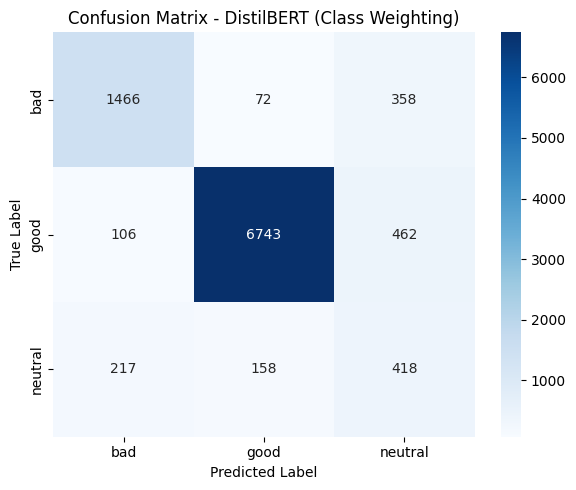

In [ ]:
# Confusion matrix
cm = confusion_matrix(trues, preds)
labels = label_encoder.classes_

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - DistilBERT (Class Weighting)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [ ]:
# Copy
y_pred_distil = preds

The fine-tuned **DistilBERT classifier** clearly outperforms all previous approaches.  
- It achieves the highest **accuracy (0.86)**, **macro F1 (0.72)**, and **weighted F1 (0.87)** across the board.  
- Class-specific scores highlight strong improvements on both **bad (0.80)** and **good (0.94)** classes.  
- While the **neutral** class remains the most challenging, its F1 (0.41) is notably higher than with static or subword embeddings.  

These results confirm the advantage of end-to-end transformer models, which capture **contextual dependencies and nuanced semantics** that are inaccessible to static embeddings or shallow classifiers.  
DistilBERT therefore represents the best-performing solution in this study, validating the transition from classical lexical models to modern transformer-based architectures.

## **Final Results**

Model Performance Comparison (per-class F1)

| Model / Embedding             | Classifier     | Accuracy | Macro F1 | Weighted F1 | F1 Bad | F1 Good | F1 Neutral |
|--------------------------------|----------------|----------|----------|-------------|--------|---------|------------|
| TF-IDF (1–2 grams)             | SVM            | 0.82     | 0.61     | 0.82        | 0.69   | 0.91    | 0.24       |
| TF-IDF (1–2–3 grams)           | SVM            | 0.83     | 0.62     | 0.82        | 0.70   | 0.91    | 0.25       |
| Word2Vec (CBOW)                | MLP            | 0.69     | 0.56     | 0.74        | 0.61   | 0.82    | 0.26       |
| Word2Vec (CBOW)                | SVM            | 0.79     | 0.56     | 0.78        | 0.63   | 0.88    | 0.18       |
| Word2Vec (Skip-Gram)           | MLP            | 0.71     | 0.59     | 0.76        | 0.64   | 0.84    | 0.28       |
| Word2Vec (Skip-Gram)           | SVM            | 0.81     | 0.60     | 0.80        | 0.68   | 0.90    | 0.23       |
| Word2Vec (Skip-Gram)         | LSTM forward           | 0.19     | 0.11     | 0.06        | 0.32   | 0.00    | 0.00       |
| Word2Vec (Skip-Gram)       | LSTM bidir.          | 0.73     | 0.28     | 0.62        | 0.00   | 0.84    | 0.00       |
| Pretrained GloVe               | MLP            | 0.70     | 0.57     | 0.74        | 0.60   | 0.82    | 0.29       |
| Pretrained GloVe               | SVM            | 0.78     | 0.57     | 0.78        | 0.63   | 0.88    | 0.20       |
| Pretrained Glove         | LSTM forward          | 0.75     | 0.61     | 0.79        | 0.63   | 0.88    | 0.31       |
| Pretrained Glove           | LSTM  bidir.       | 0.75     | 0.62     | 0.79        | 0.67   | 0.87    | 0.32       |
| FastText (pretrained)          | MLP            | 0.73     | 0.60     | 0.77        | 0.66   | 0.84    | 0.31       |
| FastText (pretrained)          | SVM            | 0.81     | 0.62     | 0.81        | 0.68   | 0.90    | 0.27       |
| FastText (pretrained)          | LSTM forward   | 0.75     | 0.62     | 0.79        | 0.70   | 0.87    | 0.31       |
| FastText (pretrained)          | LSTM bidir.    | 0.79     | 0.65     | 0.82        | 0.72   | 0.90    | 0.32       |
| FastText (trained on dataset)  | MLP            | 0.74     | 0.62     | 0.78        | 0.69   | 0.85    | 0.31       |
| FastText (trained on dataset)  | SVM            | 0.82     | 0.62     | 0.82        | 0.71   | 0.91    | 0.25       |
| FastText (trained on dataset)  | LSTM forward   | 0.79     | 0.63     | 0.81        | 0.69   | 0.90    | 0.32       |
| FastText (trained on dataset)  | LSTM bidir.    | 0.78     | 0.64     | 0.81        | 0.72   | 0.89    | 0.32       |
| FastText (supervised)          | FastText clf.  | 0.68     | 0.54     | 0.72        | 0.46   | 0.83    | 0.32       |
| Sentence-BERT                  | MLP            | 0.75     | 0.61     | 0.78        | 0.67   | 0.86    | 0.30       |
| Sentence-BERT                  | SVM            | 0.82     | 0.63     | 0.82        | 0.71   | 0.91    | 0.27       |
| DistilBERT (fine-tuned)        | Transformer    | **0.86** | **0.72** | **0.87**    | **0.80** | **0.94** | **0.41**  |

## **Interpreting Results**

To interpret the predictions of a **LinearSVC** trained on **TF-IDF vectorized text**, it's possible to use **SHAP (SHapley Additive exPlanations)**.  

- Since `LinearSVC` does not provide probabilities, explain the **decision function** (the signed distance from the separating hyperplane).  
- Then build a **KernelExplainer**, which is model-agnostic: it perturbs the input data (switching features “on/off”) and estimates the contribution of each feature by simulating the Shapley values.  
- A small sample of training data is used as the **background distribution**, and SHAP computes how much each word (TF-IDF feature) shifts the prediction  of a given document away from the average prediction.


Visualizations such as the **force plot** highlight which words push the model towards the positive or negative class:  
- **Red words** → increase the likelihood of the predicted class.  
- **Blue words** → decrease it.  


It's possible to apply a similar approach for **DistilBERT**, particularly using two complementary interpretability techniques:

- **SHAP (SHapley Additive Explanations):**  
  Works in the same way as for SVC.

- **Gradient-based attribution:**  
  By computing the gradient of the output with respect to the input embeddings, it is possible to estimate which tokens have the greatest influence on the decision. Unlike SHAP, this approach is model-specific and directly leverages DistilBERT’s internal representations.


### **Why TF-IDF + SVM sometimes outperforms other approaches?**

Load models and data:

In [ ]:
# Import and load models
model_name = 'TF-IDF'
model_rep = joblib.load(f"{recovery_dir}/TFIDF/tfidf_vectorizer.pkl")
model_class = joblib.load(f"{recovery_dir}/TFIDF/svm_weighted.pkl")
df_model = amazon_tfidf.copy()

Get **top-10 features** per class.

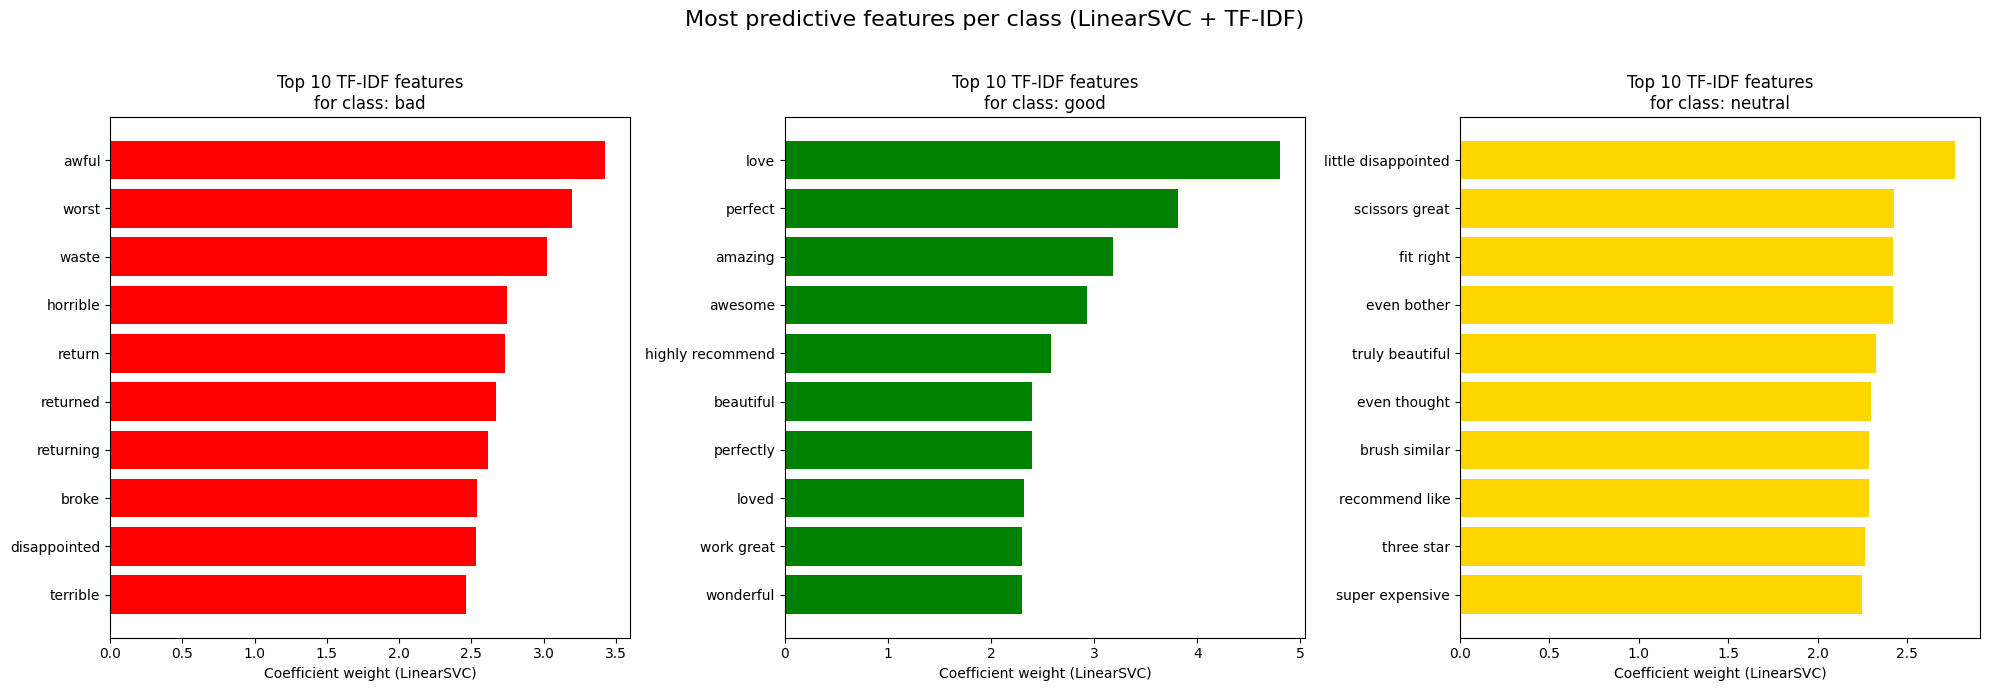

In [ ]:
# Global interpretation: top features per class
# For LinearSVC (OvR), coef_.shape == (n_classes, n_features)
feature_names = model_rep.get_feature_names_out()
coefs = model_class.coef_
class_names = list(label_encoder.classes_)  # ['bad','neutral','good']

# Choose how many top features to visualize
top_k = 10

# Plot top positive features per class (those that push towards the class)
class_colors = {"bad": "red", "neutral": "gold", "good": "green"}  # custom palette

fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharex=False)

for i, cls in enumerate(class_names):
    coef_i = coefs[i]
    top_pos_idx = np.argsort(coef_i)[-top_k:]
    top_pos_feats = feature_names[top_pos_idx]
    top_pos_vals = coef_i[top_pos_idx]

    ax = axes[i]
    ax.barh(range(top_k), top_pos_vals, color=class_colors.get(cls, "gray"))
    ax.set_yticks(range(top_k))
    ax.set_yticklabels(top_pos_feats)
    ax.set_title(f"Top {top_k} {model_name} features\nfor class: {cls}")
    ax.set_xlabel("Coefficient weight (LinearSVC)")

fig.suptitle(f"Most predictive features per class (LinearSVC + {model_name})", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Get **wordclouds** per class.

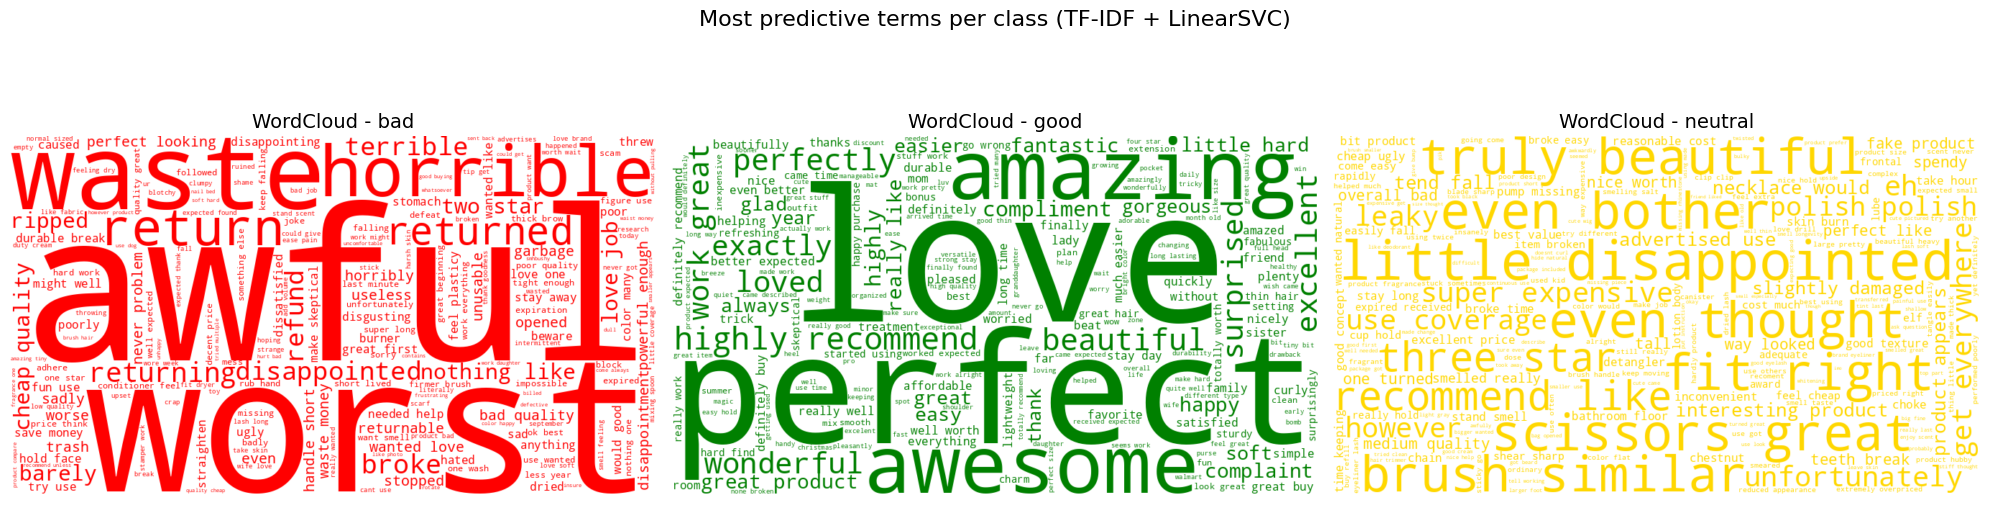

In [ ]:
# WordCloud per class (from coefficients)
def make_solid_color_func(hex_or_name):
    """Return a color function that paints every word with the same color."""
    def color_func(*args, **kwargs):
        return hex_or_name
    return color_func

# Build weights (positive coefficients only) for each class
weights_per_class = []
for i, cls in enumerate(class_names):
    coef_i = coefs[i].copy()
    coef_i[coef_i < 0] = 0.0  # keep only positive contributions toward class i
    weights = {feature_names[j]: float(coef_i[j]) for j in range(len(feature_names)) if coef_i[j] > 0}
    weights_per_class.append((cls, weights))

# Plot in a single 1x3 window
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for idx, (cls, weights) in enumerate(weights_per_class):
    ax = axes[idx]
    ax.axis("off")
    if not weights:
        ax.set_title(f"No positive-weight features for class: {cls}", color=class_colors.get(cls, "black"))
        continue

    wc = WordCloud(
        width=900, height=500, background_color="white", prefer_horizontal=0.95, collocations=False,
        normalize_plurals=True, min_font_size=6).generate_from_frequencies(weights)

    # Recolor all words to the class color
    wc_colored = wc.recolor(color_func=make_solid_color_func(class_colors.get(cls, "black")))

    ax.imshow(wc_colored, interpolation="bilinear")
    ax.set_title(f"WordCloud - {cls}", fontsize=14)

fig.suptitle("Most predictive terms per class (TF-IDF + LinearSVC)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

### **Explainability Methods: TF-IDF + SVM vs DistilBERT**

Prepare data:

In [ ]:
# Preprocessed text and labels
texts = amazon_tfidf["text"].tolist()
labels = amazon_tfidf["vote"]

label_encoder = LabelEncoder()
y_all = label_encoder.fit_transform(labels)

# Split BEFORE TF-IDF
X_train_texts, X_test_texts, y_train_raw, y_test_raw = train_test_split(
    texts, y_all, test_size=0.2, stratify=y_all, random_state=42
)

# Do the same on original data
X_train_texts_origin, X_test_texts_origin, y_train_raw_origin, y_test_raw_origin = train_test_split(
    amazon_df["text"].tolist(), y_all, test_size=0.2, stratify=y_all, random_state=42
)

# Fit TF-IDF only on original training texts
project_dir = f"{recovery_dir}/TFIDF"
file_path = f"{project_dir}/tfidf_vectorizer.pkl"

tfidf = joblib.load(file_path)

# Transform training and test sets before balancing
X_train_tfidf = tfidf.transform(X_train_texts)
X_test_tfidf = tfidf.transform(X_test_texts)

# Import or initialize and train classifier
svm_tfidf = SVM_training(X_train=X_train_tfidf, y_train=y_train_raw, file_path=f"{project_dir}/svm_weighted.pkl")

# Predictions with TF-IDF + SVM
y_pred_tfidf = svm_tfidf.predict(X_test_tfidf)

SVM already trained. Importing classifier..


Extract some examples on which apply explainability methods:

In [ ]:
# Decode labels into original strings
y_test_str       = label_encoder.inverse_transform(y_test)
y_pred_tfidf_str = label_encoder.inverse_transform(y_pred_tfidf)
y_pred_distil_str= label_encoder.inverse_transform(y_pred_distil)

# Get examples on which apply explainability methods
examples = {}

for i, (true, pred_tfidf, pred_distil) in enumerate(zip(y_test_str, y_pred_tfidf_str, y_pred_distil_str)):

    # Case 1: Both correct
    if true == pred_tfidf == pred_distil and "both_correct" not in examples:
        examples["both_correct"] = (i, X_test_texts_origin[i], true, pred_tfidf, pred_distil)

    # Case 2: Correct for DistilBERT, wrong for TF-IDF
    if pred_distil == true and pred_tfidf != true and "distil_only" not in examples:
        examples["distil_only"] = (i, X_test_texts_origin[i], true, pred_tfidf, pred_distil)

    # Case 3: Correct for TF-IDF, wrong for DistilBERT
    if pred_tfidf == true and pred_distil != true and "tfidf_only" not in examples:
        examples["tfidf_only"] = (i, X_test_texts_origin[i], true, pred_tfidf, pred_distil)

    # Case 4: Both wrong, but disagree
    if pred_tfidf != true and pred_distil != true and pred_tfidf != pred_distil and "both_wrong_disagree" not in examples:
        examples["both_wrong_disagree"] = (i, X_test_texts_origin[i], true, pred_tfidf, pred_distil)

    # Case 5: Neutral but both wrong
    if true == "neutral" and pred_tfidf != true and pred_distil != true and "neutral_both_wrong" not in examples:
        examples["neutral_both_wrong"] = (i, X_test_texts_origin[i], true, pred_tfidf, pred_distil)

    # Stop if we already have all cases
    if len(examples) == 5:
        break

# Print results
for case, (idx, text, true, tfidf_pred, distil_pred) in examples.items():
    print(f"\n[{case.upper()}] idx={idx}")
    print(f"True label: {true}, TF-IDF: {tfidf_pred}, DistilBERT: {distil_pred}")
    print(f"Review: {text}")


[BOTH_CORRECT] idx=0
True label: bad, TF-IDF: bad, DistilBERT: bad
Review: This did nothing like the videos. My face does feel softer and my pores look smaller. It's nothing like the advertisements. I am disappointed.

[DISTIL_ONLY] idx=3
True label: good, TF-IDF: neutral, DistilBERT: good
Review: Just not enough frontal but still great it’s Soft got a few wears

[TFIDF_ONLY] idx=8
True label: bad, TF-IDF: bad, DistilBERT: neutral
Review: It’s pretty difficult to apply to where you can see it (I have very blond hair so I can’t see this working in darker hair) and then it comes out too easily even when brushed. It also made my hair crunchy and dry. Comes right out when washed though.

[BOTH_WRONG_DISAGREE] idx=25
True label: bad, TF-IDF: good, DistilBERT: neutral
Review: Doesn't hold a charge long enough to take gel polish off a whole hand It's easy to hold

[NEUTRAL_BOTH_WRONG] idx=59
True label: neutral, TF-IDF: bad, DistilBERT: bad
Review: These are odd in the sense that some produc

Apply **SHAP** on TF-IDF + SVM:

In [ ]:
# Function for SVM decision function
f = lambda x: model_class.decision_function(x)

# Build explainer
X_train_sample = shap.sample(X_train_tfidf, 40)
SHAP_explainer = shap.KernelExplainer(f, X_train_sample)

# Decision scores on full test set
# Get the indices of extracted examples (from the examples dict you built earlier)
selected_indices = [examples[case][0] for case in examples]  # idx of each case
example_texts = [X_test_texts[idx] for idx in selected_indices]
example_features = X_test_tfidf[selected_indices]  # shape = (n_examples, n_features)

X_test_subset = tfidf.transform(example_texts)
decision_scores = model_class.decision_function(X_test_subset)

n_classes = decision_scores.shape[1]
y_pred = model_class.predict(X_test_subset)

# Subset with only those examples
test_raw_texts_subset = example_texts
y_pred_subset = model_class.predict(X_test_subset)

In [ ]:
# Plot explanations
for j, txt in enumerate(example_texts):
    # Compute SHAP values
    shap_vals = SHAP_explainer.shap_values(X_test_subset[j])

    text_html = f"""
    <div style="border:1px solid #ccc; padding:10px; margin:10px 0;">
        <h3>Original text:</h3>
        <p>{txt}</p>
    </div>
    """
    display(HTML(text_html))

    for cl in range(n_classes):
        shap_value = shap_vals[0][:, cl]  # j indexes into subset
        class_name = label_encoder.inverse_transform([cl])[0]

        # Add a title above each plot
        display(HTML(f"<h4>Explanation for class {cl}: {class_name}</h4>"))

        shap.initjs()
        fp = shap.plots.force(
            SHAP_explainer.expected_value[cl],
            shap_value,
            feature_names=model_rep.get_feature_names_out()
        )
        display(fp)

Output hidden; open in https://colab.research.google.com to view.

The TF-IDF + SVM classifier performs well when reviews contain **strong, polarized lexical cues** (e.g., *difficult apply*), reflecting the strength of lexical models in detecting explicit sentiment.  

However, several limitations emerge:
- In **short or sparse reviews**, the absence of strong markers often leads to misclassifications.  
- SHAP highlights **misaligned feature importance**, with prototypical positive words (e.g., *love*) sometimes contributing to negative predictions.  
- This issue is partly due to SHAP in sparse vector spaces: the **absence** of highly weighted positive words may itself push predictions toward the negative class.  

Overall, TF-IDF + SVM struggles with (1) misaligned feature importance, (2) lack of contextual awareness, and (3) confusion between polar classes.

Get explainations for DistilBERT with Gradient Based method:

In [ ]:
# Path to fine-tuned DistilBERT
model_path = f"{recovery_dir}/DistilBERT"

# Labels
id2label = {0: "bad", 1: "neutral", 2: "good"}
label2id = {"bad": 0, "neutral": 1, "good": 2}

# Load tokenizer + model
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(model_path,
                                                           id2label=id2label,
                                                           label2id=label2id).to("cuda")

# Create explainer (single-label classification)
cls_explainer = MultiLabelClassificationExplainer(
    model,
    tokenizer,
)


# Preprocessed text and labels
texts = amazon_bert["text"].tolist()
labels = amazon_bert["vote"]

label_encoder = LabelEncoder()
y_all = label_encoder.fit_transform(labels)

# Split BEFORE TF-IDF
X_train_texts, X_test_texts, y_train_raw, y_test_raw = train_test_split(
    texts, y_all, test_size=0.2, stratify=y_all, random_state=42
)

# Collect raw texts of your extracted examples
selected_cases = ["both_correct", "distil_only", "tfidf_only", "both_wrong_disagree", "neutral_both_wrong"]
selected_texts = [X_test_texts[examples[case][0]] for case in selected_cases]
selected_true = {case: examples[case][2] for case in selected_cases}

# Loop over all cases
for case, text in zip(selected_cases, selected_texts):
    print(f"\nExplaining case: {case}")

    # Get true label
    true_label = selected_true[case]
    # Compute attributions
    word_attributions = cls_explainer(text)
    # Visualization
    _ = cls_explainer.visualize(true_class=true_label)


Explaining case: both_correct



Explaining case: distil_only


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
good,(0.03),bad,-1.42,[CLS] just not enough frontal but still great it ’ s soft got a few wears [SEP]
good,(0.95),neutral,0.71,[CLS] just not enough frontal but still great it ’ s soft got a few wears [SEP]
good,(0.46),good,0.16,[CLS] just not enough frontal but still great it ’ s soft got a few wears [SEP]



Explaining case: tfidf_only



Explaining case: both_wrong_disagree


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
bad,(0.73),bad,0.60,[CLS] doesn ' t hold a charge long enough to take gel polish off a whole hand it ' s easy to hold [SEP]
bad,(0.03),neutral,-1.04,[CLS] doesn ' t hold a charge long enough to take gel polish off a whole hand it ' s easy to hold [SEP]
bad,(0.84),good,1.43,[CLS] doesn ' t hold a charge long enough to take gel polish off a whole hand it ' s easy to hold [SEP]



Explaining case: neutral_both_wrong


Apply also SHAP on DistilBERT:

In [ ]:
# Path to fine-tuned DistilBERT
model_path = f"{recovery_dir}/DistilBERT"

# Load tokenizer and model
id2label = {0: "bad", 1: "neutral", 2: "good"}
label2id = {"bad": 0, "neutral": 1, "good": 2}
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(model_path,
    id2label=id2label,
    label2id=label2id).to("cuda")
model.eval()

# Create classification pipeline (returns all class probabilities)
pred = transformers.pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0,  # 0 = first GPU, -1 = CPU
    return_all_scores=True
)

# Create SHAP explainer
shap_explainer = shap.Explainer(pred)

Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
# Plot
shap_values = shap_explainer(selected_texts)
shap.plots.text(shap_values)

Output hidden; open in https://colab.research.google.com to view.

For DistilBERT, both SHAP and gradient-based methods confirm its **contextual sensitivity**: importance is assigned only when sentiment-bearing tokens appear in meaningful contexts.  
- Negations, modifiers, and intensifiers (e.g., *not*, *still*, *pretty*) are correctly modeled, avoiding misinterpretations typical of count-based methods.  
- Unlike SVM, DistilBERT does not over-rely on isolated strong words but captures **interactions within phrases** (e.g., *doesn’t hold a charge*).  
- In ambiguous reviews, the model distributes importance across multiple tokens, recognizing **weak or indirect sentiment cues**.  

Interpretability thus shows that DistilBERT’s superior performance stems not only from pretraining, but also from its **architectural ability to model context, compositionality, and syntax**, making it more reliable for naturalistic reviews where meaning depends on structure rather than isolated keywords.

## **References**

- [Mikolov et al., 2013 – Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781)
- [Gensim data repository](https://github.com/RaRe-Technologies/gensim-data)
- [Exploring Sentence Embeddings: How Sentence-BERT and DistilBERT Capture Meaning](https://medium.com/@khushisinha16/exploring-sentence-embeddings-how-sentence-bert-and-distilbert-capture-meaning-b040ebb50c9a)
- [Word2Vec for Text Classification (Spot Intelligence)](https://spotintelligence.com/2023/02/15/word2vec-for-text-classification/#:~:text=Word2Vec%20is%20a%20popular%20algorithm,a%20large%20corpus%20of%20text.)
- [Can TF-IDF be used for Text Classification? (Crawlspider)](https://www.crawlspider.com/can-tf-idf-be-used-for-text-classification-how/#:~:text=The%20TF%2DIDF%20matrix%20is,Good%20for%20text%20classification%20tasks.)
- [Word Embedding Techniques: Word2Vec and TF-IDF Explained](https://medium.com/data-science/word-embedding-techniques-word2vec-and-tf-idf-explained-c5d02e34d08)
- [Top 5 Pre-trained Word Embeddings](https://patil-aakanksha.medium.com/top-5-pre-trained-word-embeddings-20de114bc26)
- [FastText: Working and Implementation (GeeksforGeeks)](https://www.geeksforgeeks.org/machine-learning/fasttext-working-and-implementation/)
- [Facebook FastText official documentation](https://fasttext.cc/docs/en/unsupervised-tutorial.html)
- [Intro to NLP Word Embeddings for Classification (Edumunozsala Blog)](https://edumunozsala.github.io/BlogEms/jupyter/nlp/classification/embeddings/python/2020/08/15/Intro_NLP_WordEmbeddings_Classification.html)
- [Text Classification using LSTM](https://medium.com/@gagangupta_82781/text-classification-using-lstm-7e4cc30f6232)
- [NLP Text Classification (SMC Tech Blog)](https://techblog.smc.it/en/2020-12-21/nlp-text-clf)
- [DistilBERT: A Distilled Version of BERT (Zilliz)](https://zilliz.com/learn/distilbert-distilled-version-of-bert)
- [Fine-tuning BERT for Text Classification using Hugging Face](https://medium.com/@rajratangulab.more/fine-tuning-bert-for-text-classification-using-hugging-face-transformers-685c132d185d)
- [Building a Text Classification Model using DistilBERT](https://medium.com/@prakashram1327/building-a-text-classification-model-using-distilbert-703c1409696c)
- [Facebook FastText GitHub repository](https://github.com/facebookresearch/fastText?tab=readme-ov-file#word-representation-learning)